In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import GCNConv
import torch.nn as nn

In [2]:
import optbinning
from optbinning import BinningProcess, OptimalBinning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

(CVXPY) May 24 12:54:35 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 24 12:54:35 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/Users/alessandrofogli/miniconda3/envs/thesis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
df = pd.read_csv('data/german/german.csv')
df

,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,Male,0,1,67,6,Electronics,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,-1,Female,0,0,22,48,Electronics,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1,Male,0,1,49,12,Education,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,1,Male,0,1,45,42,Furniture,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,-1,Male,0,1,53,24,NewCar,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,Female,0,0,31,12,Furniture,1736,3,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
996,1,Male,0,0,40,30,UsedCar,3857,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
997,1,Male,0,1,38,12,Electronics,804,4,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
998,-1,Male,0,1,23,45,Electronics,1845,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
df.replace({'GoodCustomer' : { -1 : 1, 1 : 0}}, inplace=True)
df.rename(columns={"GoodCustomer": "BadCustomer"}, inplace=True)

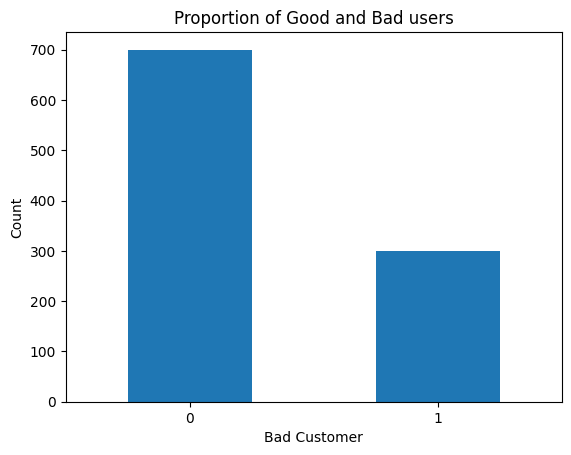

In [6]:
ax = df['BadCustomer'].value_counts().plot(kind='bar')
ax.set_xlabel('Bad Customer')
ax.set_ylabel('Count')
ax.set_title('Proportion of Good and Bad users')
ax.set_xticklabels(ax.get_xticklabels(), rotation=360)
plt.savefig('BadCustomer.png', transparent=True, dpi=200)
plt.show()

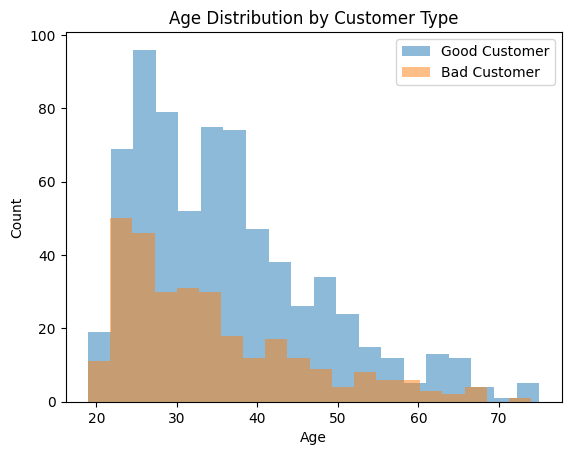

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(df[df['BadCustomer'] == 0]['Age'], bins=20, alpha=0.5, label='Good Customer')
ax.hist(df[df['BadCustomer'] == 1]['Age'], bins=20, alpha=0.5, label='Bad Customer')

ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Age Distribution by Customer Type')

ax.legend(loc='upper right')
plt.savefig('AgeDistribution.png', transparent=True, dpi=200)
plt.show()


In [8]:
print(f"Average observed default rate : {df['BadCustomer'].mean():.2%}")

Average observed default rate : 30.00%


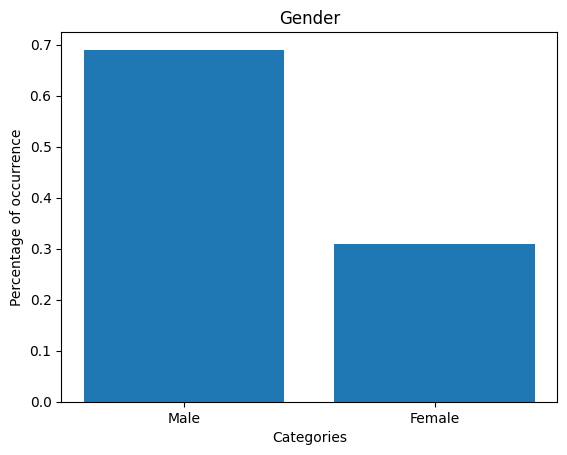

In [9]:
# Create a sample dataset
gender = df['Gender']
counts = gender.value_counts(normalize=True)
plt.bar(counts.index, counts.values)
plt.title('Gender')
plt.xlabel('Categories')
plt.ylabel('Percentage of occurrence')
plt.show()


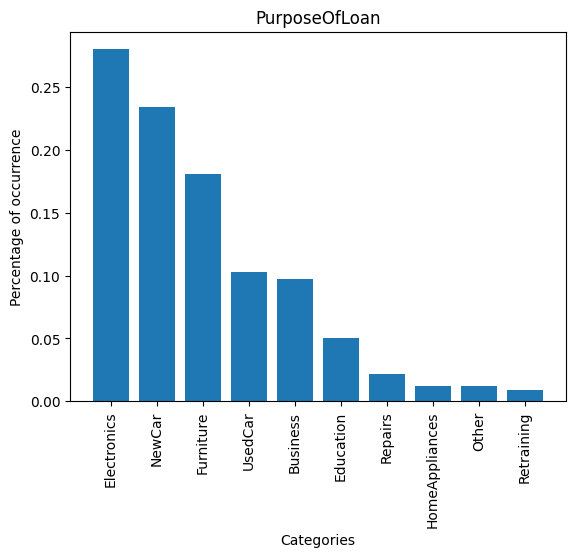

In [10]:
# Create a sample dataset
gender = df['PurposeOfLoan']
counts = gender.value_counts(normalize=True)

# Create the plot and rotate the x-axis labels
plt.bar(counts.index, counts.values)
plt.title('PurposeOfLoan')
plt.ylabel('Percentage of occurrence')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.xlabel('Categories')

plt.show()


In [11]:
# mirroring statsmodels logistic regression
lr_params = {
    "fit_intercept": True,
    "penalty": "none",
    "random_state": 72,
    "solver": "newton-cg",
    }

# economic relationships with defaults for WOE
binning_fit_params_woe = {
    "Gender": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": np.array([
             [True], 
             [False], 
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
        ],
        "solver" : "mip"
    },
    
    "ForeignWorker": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": np.array([
             [False], 
             [True], 
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
        ],
        "solver" : "mip"
    },
    "Single": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "Age": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": np.array([
             25.50, 48.50
        ]),
        "user_splits_fixed": [
            True,
            True,
        
        ],
        "solver" : "mip"
    },
    "LoanDuration": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": np.array([
             11.50, 17, 27.5, 43.5
        ]),
        "user_splits_fixed": [
            True,
            True,
            True,
            True
        ],
        "solver" : "mip"
    },
    "PurposeOfLoan": {
        "dtype": "categorical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },

    "LoanAmount": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": np.array([
             4049.50, 9214.00,
        ]),
        "user_splits_fixed": [
            True,
            True,
        
        ],
        "solver" : "mip"
    },
    "LoanRateAsPercentOfIncome": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": np.array([
             3.5,
        ]),
        "user_splits_fixed": [
            True,
        ],
        "solver" : "mip"
    },
    "YearsAtCurrentHome": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "NumberOfOtherLoansAtBank": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "NumberOfLiableIndividuals": {
        "dtype": "numerical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "HasTelephone": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "CheckingAccountBalance_geq_0": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "CheckingAccountBalance_geq_200": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "SavingsAccountBalance_geq_100": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "SavingsAccountBalance_geq_500": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "MissedPayments": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "NoCurrentLoan": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": np.array([
             [False], 
             [True], 
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
        ],
        "solver" : "mip"
    },
    "CriticalAccountOrLoansElsewhere": {
        "dtype": "categorical",
        "monotonic_trend": 'ascending',
        "user_splits": np.array([
             [False], 
             [True], 
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
        ],
        "solver" : "mip"
    },
    "OtherLoansAtBank": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "OtherLoansAtStore": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "HasCoapplicant": {
        "dtype": "categorical",
        "monotonic_trend": 'auto_asc_desc',
        "user_splits": np.array([
             [False], 
             [True], 
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
        ],
        "solver" : "mip"
    },
    "HasGuarantor": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "OwnsHouse": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "RentsHouse": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "Unemployed": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "YearsAtCurrentJob_lt_1": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "YearsAtCurrentJob_geq_4": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
    "JobClassIsSkilled": {
        "dtype": "categorical",
        "monotonic_trend": None,
        "user_splits": None,
        "user_splits_fixed": None,
        "solver" : "mip"
    },
}

In [91]:
def ob_univariate(x, y, feature_name, dtype, user_splits, user_splits_fixed, monotonic_trend, plot):

    """dev only"""

    # initialize binning
    optb = OptimalBinning(
        name=feature_name, 
        dtype=dtype,
        user_splits = user_splits,
        user_splits_fixed = user_splits_fixed,
        solver="mip", 
        monotonic_trend=monotonic_trend)

    # fit transform x_train
    x_woe = optb.fit_transform(x, y)

    # report
    # if plot == True:
    #     print(optb.binning_table.build())
    #     optb.binning_table.plot(metric="event_rate") #woe
    if plot == True:
        binning_table = optb.binning_table
        binning_df = pd.DataFrame(binning_table.build())
        print(binning_df) #[['Bin', 'Event rate', 'WoE']]
        print(binning_table.analysis(pvalue_test="chi2"))
        print(binning_table.plot(metric="event_rate",show_bin_labels=True))

    return x_woe

def create_woe_pipeline(X_train, X_test, y_train, y_test):

    binning_process = BinningProcess(
        variable_names=list(X_train.columns),
        binning_fit_params=binning_fit_params_woe,
    )

    logreg = LogisticRegression(fit_intercept=True, penalty='none')

    pipeline = Pipeline(steps=[("binning_process", binning_process), ("regressor", logreg)])

    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred_f1 = (y_pred_proba >= 0.5).astype(int)  # Apply threshold and convert to binary labels
    

    y_pred = pipeline.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, y_pred_f1)
    roc_auc = roc_auc_score(y_test, y_pred)
    gini = roc_auc*2-1
    
    print(f"Gini : {gini}")
    print(f"ROC-AUC : {roc_auc}")
    print(f"F1 Score : {f1}")

    return pipeline

In [13]:
df_copy = df.copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df_copy[[  'Gender', 'PurposeOfLoan','ForeignWorker', 'Single', 'Age',
       'LoanDuration', 'LoanAmount',
       'LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
       'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
       'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed',
       'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4',
       'JobClassIsSkilled']],
    df_copy['BadCustomer'],
    test_size=0.3,
    random_state=62
    )

ForeignWorker 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0        [True]     25   0.035714         23      2    0.080000  1.622114   
1       [False]    675   0.964286        463    212    0.314074 -0.039092   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.061607  0.006954  
1       0.001485  0.000186  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.063091  0.007140  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.03797931
    IV (Jeffrey)             0.06309146
    JS (Jensen-Shannon)      0.00713962
    Hellinger                0.00749032
    Triangular               

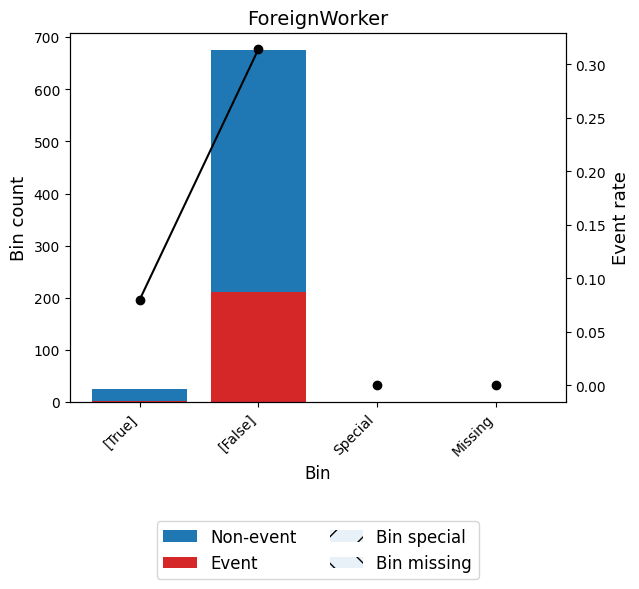

None


---

Single 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    381   0.544286        278    103    0.270341   0.17266   
1           [0]    319   0.455714        208    111    0.347962 -0.192225   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.015662  0.001955  
1       0.017436  0.002176  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.033098  0.004131  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09070805
    IV (Jeffrey)             0.03309794
    JS (Jensen-Shannon)      0.00413146
    Hellinger                0.00413435
    Triangular               0.01650

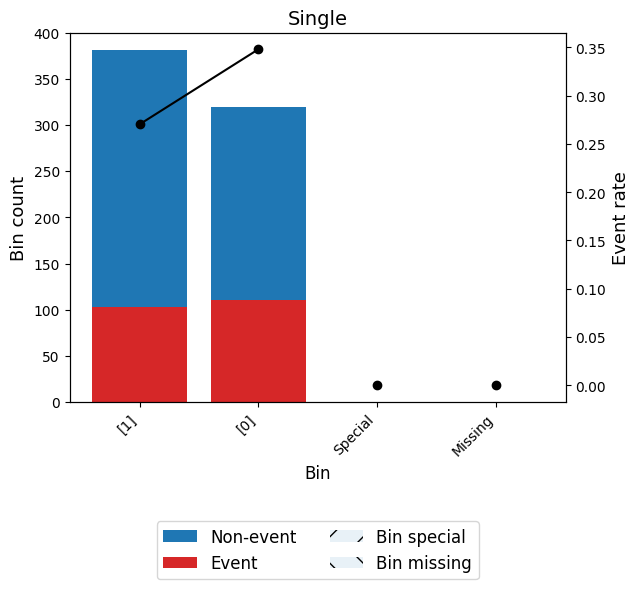

None


---

Age 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 25.50)    136   0.194286         77     59    0.433824   
1       [25.50, 48.50)    473   0.675714        340    133    0.281184   
2         [48.50, inf)     91   0.130000         69     22    0.241758   
3              Special      0   0.000000          0      0    0.000000   
4              Missing      0   0.000000          0      0    0.000000   
Totals                    700   1.000000        486    214    0.305714   

             WoE        IV        JS  
0      -0.553965  0.064961  0.008018  
1       0.118364  0.009243  0.001155  
2       0.322831  0.012646  0.001574  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.086850  0.010746  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.13358140
    

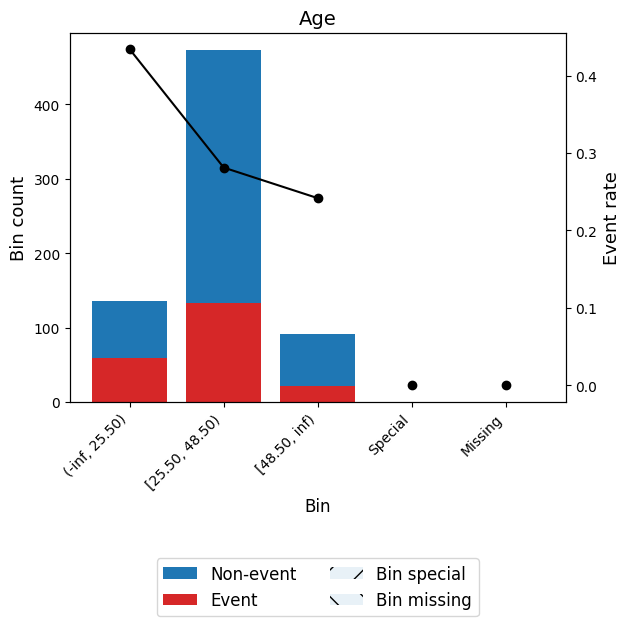

None


---

LoanDuration 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 11.50)    130   0.185714        112     18    0.138462   
1       [11.50, 17.00)    176   0.251429        129     47    0.267045   
2       [17.00, 27.50)    243   0.347143        165     78    0.320988   
3       [27.50, 43.50)     99   0.141429         60     39    0.393939   
4         [43.50, inf)     52   0.074286         20     32    0.615385   
5              Special      0   0.000000          0      0    0.000000   
6              Missing      0   0.000000          0      0    0.000000   
Totals                    700   1.000000        486    214    0.305714   

             WoE        IV        JS  
0       1.007895  0.147496  0.017694  
1       0.189432  0.008677  0.001083  
2      -0.070996  0.001773  0.000222  
3       -0.38945  0.022894  0.002844  
4      -1.290236  0.139836  0.016360  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000000  
Totals

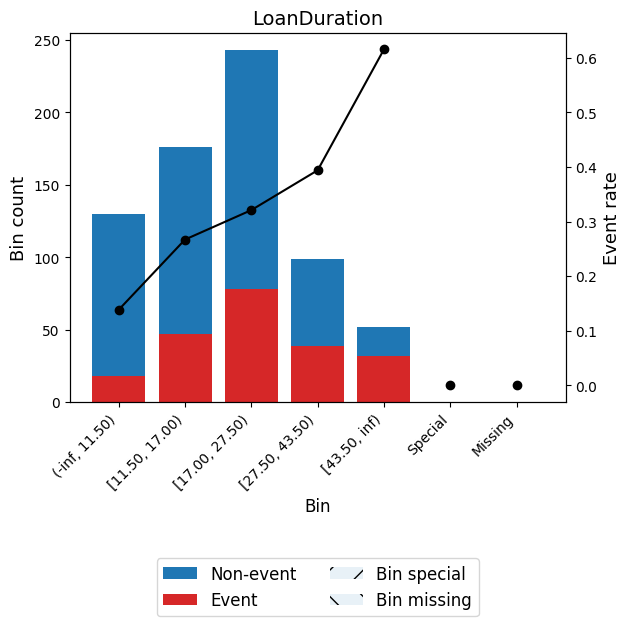

None


---

LoanAmount 

                       Bin  Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 4049.50)    531   0.758571        393    138    0.259887   
1       [4049.50, 9214.00)    134   0.191429         80     54    0.402985   
2           [9214.00, inf)     35   0.050000         13     22    0.628571   
3                  Special      0   0.000000          0      0    0.000000   
4                  Missing      0   0.000000          0      0    0.000000   
Totals                        700   1.000000        486    214    0.305714   

             WoE        IV        JS  
0       0.226323  0.037068  0.004624  
1       -0.42719  0.037476  0.004649  
2      -1.346326  0.102394  0.011913  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.176938  0.021185  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini 

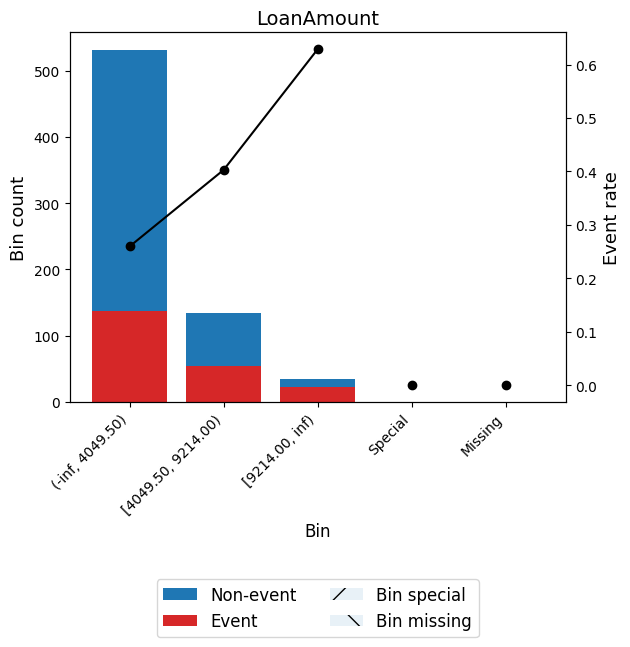

None


---

LoanRateAsPercentOfIncome 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 3.50)    374   0.534286        270    104    0.278075   
1        [3.50, inf)    326   0.465714        216    110    0.337423   
2            Special      0   0.000000          0      0    0.000000   
3            Missing      0   0.000000          0      0    0.000000   
Totals                  700   1.000000        486    214    0.305714   

             WoE        IV        JS  
0       0.133798  0.009309  0.001163  
1      -0.145435  0.010119  0.001264  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.019427  0.002426  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06957425
    IV (Jeffrey)             0.01942743
    JS (Jensen-Shannon)      0.00242645
    Hellinger              

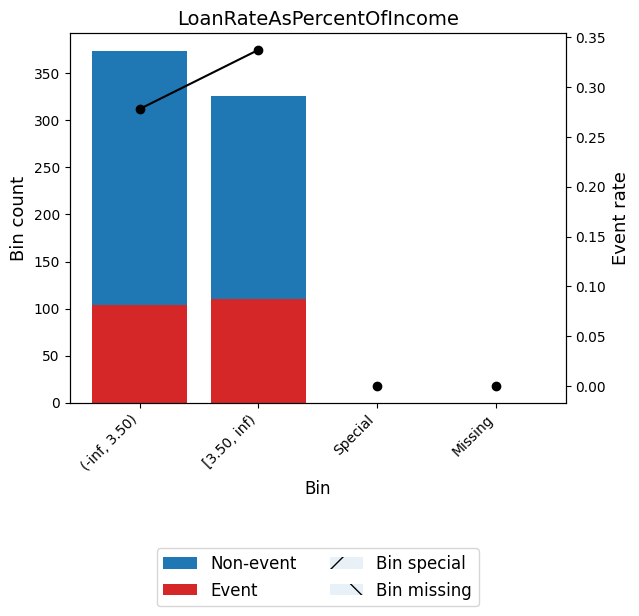

None


---

YearsAtCurrentHome 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 1.50)     92   0.131429         65     27    0.293478   
1       [1.50, 3.50)    332   0.474286        230    102    0.307229   
2        [3.50, inf)    276   0.394286        191     85    0.307971   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                  700   1.000000        486    214    0.305714   

             WoE        IV        JS  
0       0.058318  0.000442  0.000055  
1      -0.007126  0.000024  0.000003  
2       -0.01061  0.000044  0.000006  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.000510  0.000064  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00823045
   

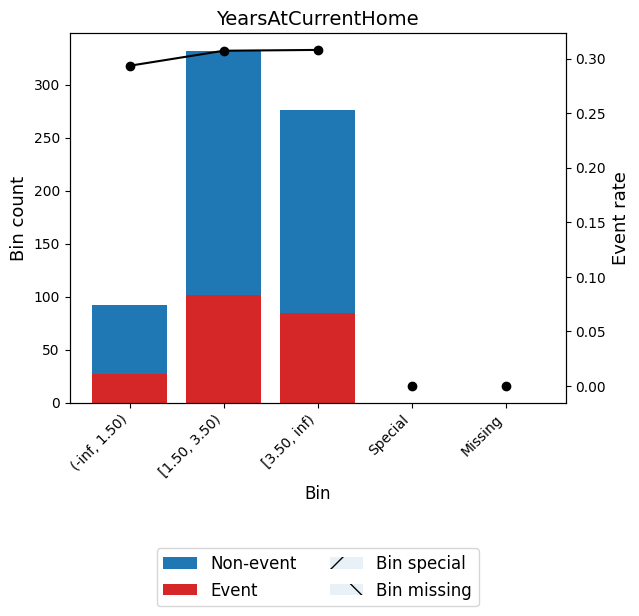

None


---

NumberOfOtherLoansAtBank 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 1.50)    455       0.65        308    147    0.323077   
1        [1.50, inf)    245       0.35        178     67    0.273469   
2            Special      0       0.00          0      0    0.000000   
3            Missing      0       0.00          0      0    0.000000   
Totals                  700       1.00        486    214    0.305714   

             WoE        IV        JS  
0      -0.080565  0.004284  0.000535  
1       0.156858  0.008340  0.001041  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.012624  0.001577  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05317103
    IV (Jeffrey)             0.01262406
    JS (Jensen-Shannon)      0.00157680
    Hellinger               

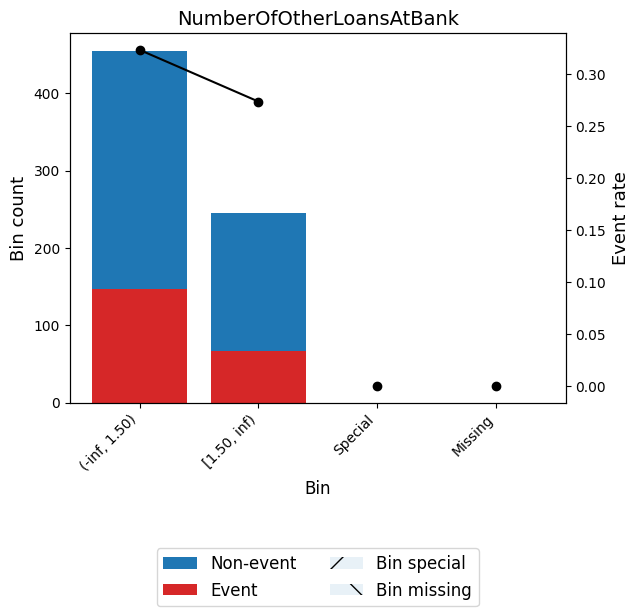

None


---

NumberOfLiableIndividuals 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 1.50)    582   0.831429        402    180    0.309278   
1        [1.50, inf)    118   0.168571         84     34    0.288136   
2            Special      0   0.000000          0      0    0.000000   
3            Missing      0   0.000000          0      0    0.000000   
Totals                  700   1.000000        486    214    0.305714   

             WoE        IV        JS  
0      -0.016737  0.000234  0.000029  
1       0.084224  0.001176  0.000147  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.001410  0.000176  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01396100
    IV (Jeffrey)             0.00140952
    JS (Jensen-Shannon)      0.00017615
    Hellinger              

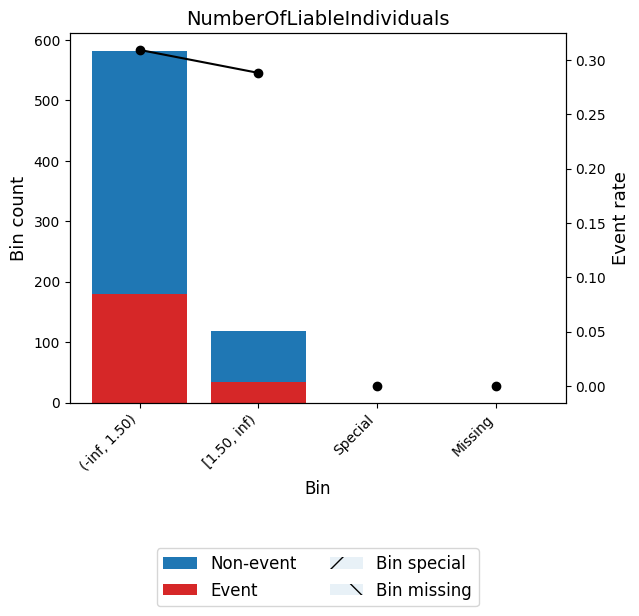

None


---

HasTelephone 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    273       0.39        194     79    0.289377  0.078178   
1           [0]    427       0.61        292    135    0.316159 -0.048754   
2       Special      0       0.00          0      0    0.000000       0.0   
3       Missing      0       0.00          0      0    0.000000       0.0   
Totals             700       1.00        486    214    0.305714             

              IV        JS  
0       0.002347  0.000293  
1       0.001463  0.000183  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.003810  0.000476  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.03001808
    IV (Jeffrey)             0.00381023
    JS (Jensen-Shannon)      0.00047619
    Hellinger                0.00047623
    Triangular               0

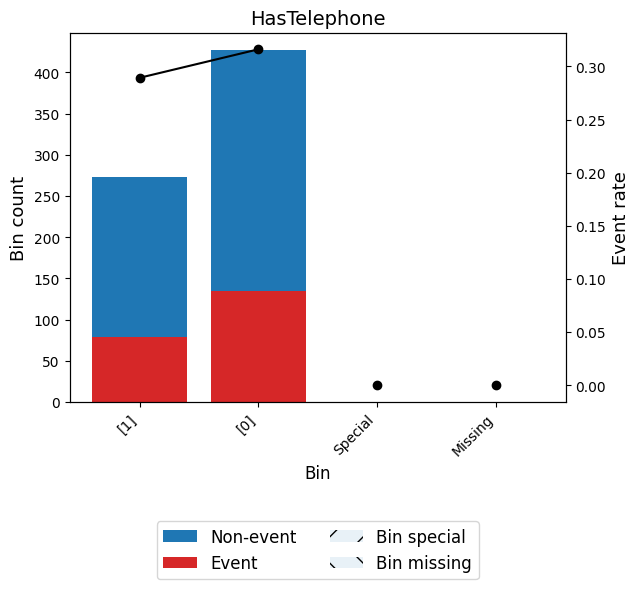

None


---

CheckingAccountBalance_geq_0 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]    464   0.662857        338    126    0.271552  0.166531   
1           [1]    236   0.337143        148     88    0.372881 -0.300357   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.017767  0.002218  
1       0.032045  0.003991  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.049811  0.006209  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.10668820
    IV (Jeffrey)             0.04981150
    JS (Jensen-Shannon)      0.00620889
    Hellinger                0.00621764
    Triangular

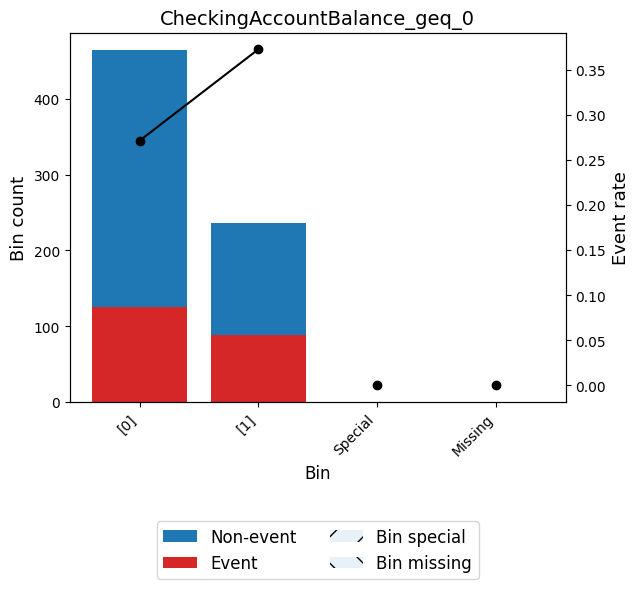

None


---

CheckingAccountBalance_geq_200 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]     47   0.067143         36     11    0.234043  0.365391   
1           [0]    653   0.932857        450    203    0.310873 -0.024191   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.008284  0.001030  
1       0.000548  0.000069  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.008833  0.001098  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.02267220
    IV (Jeffrey)             0.00883268
    JS (Jensen-Shannon)      0.00109836
    Hellinger                0.00110121
    Triangul

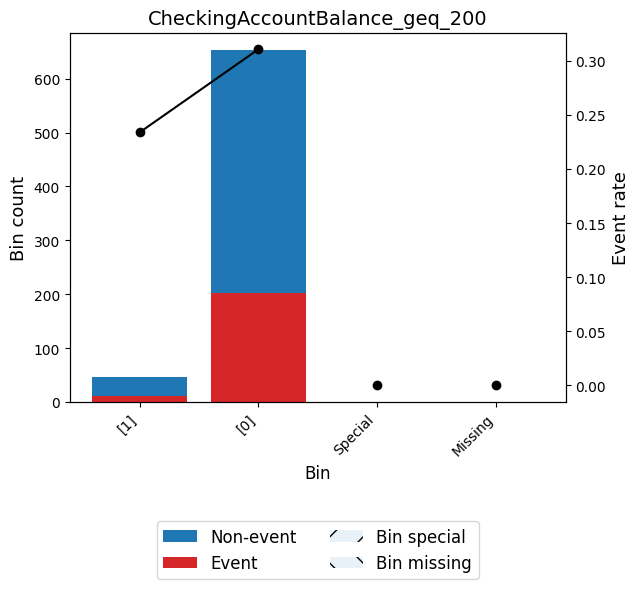

None


---

SavingsAccountBalance_geq_100 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    149   0.212857        112     37    0.248322  0.287348   
1           [0]    551   0.787143        374    177    0.321234 -0.072127   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.016538  0.002060  
1       0.004151  0.000519  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.020690  0.002579  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05755548
    IV (Jeffrey)             0.02068975
    JS (Jensen-Shannon)      0.00257902
    Hellinger                0.00258261
    Triangula

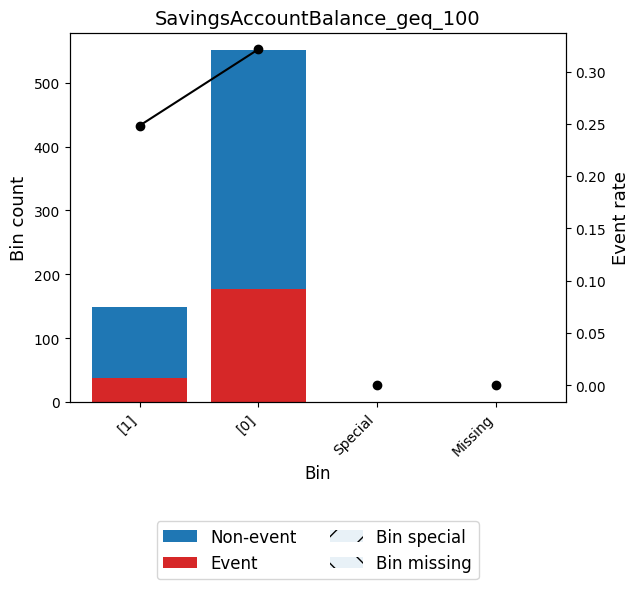

None


---

SavingsAccountBalance_geq_500 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]     79   0.112857         66     13    0.164557  0.804473   
1           [0]    621   0.887143        420    201    0.323671 -0.083283   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.060380  0.007350  
1       0.006251  0.000781  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.066630  0.008131  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07505481
    IV (Jeffrey)             0.06663032
    JS (Jensen-Shannon)      0.00813141
    Hellinger                0.00822854
    Triangula

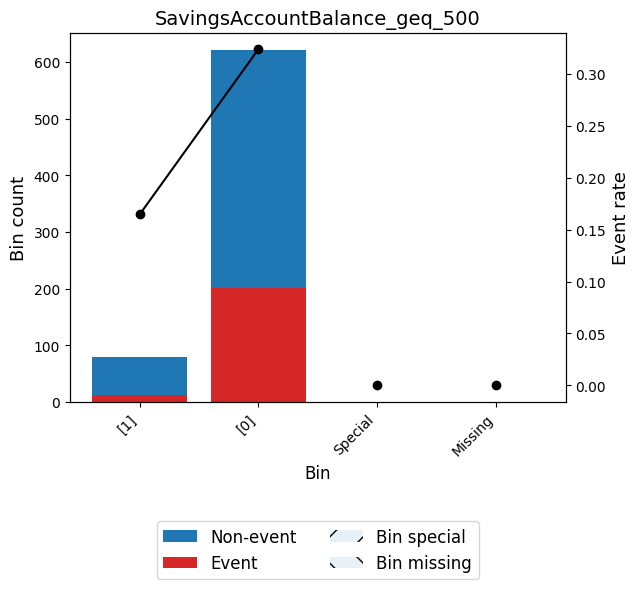

None


---

MissedPayments 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    640   0.914286        445    195    0.304688  0.004842   
1           [0]     60   0.085714         41     19    0.316667   -0.0511   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.000021  0.000003  
1       0.000226  0.000028  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.000247  0.000031  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00442291
    IV (Jeffrey)             0.00024742
    JS (Jensen-Shannon)      0.00003093
    Hellinger                0.00003093
    Triangular              

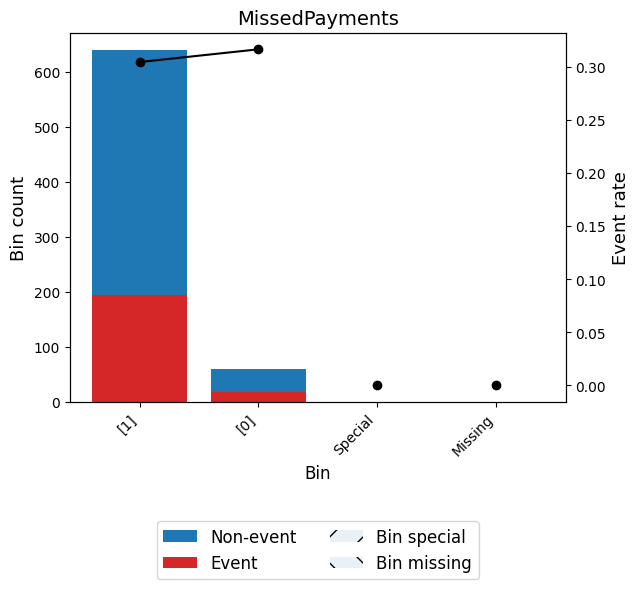

None


---

NoCurrentLoan 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0       [False]    666   0.951429        471    195    0.292793  0.061626   
1        [True]     34   0.048571         15     19    0.558824 -1.056621   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.003569  0.000446  
1       0.061200  0.007313  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.064770  0.007759  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05792085
    IV (Jeffrey)             0.06476983
    JS (Jensen-Shannon)      0.00775904
    Hellinger                0.00792309
    Triangular               

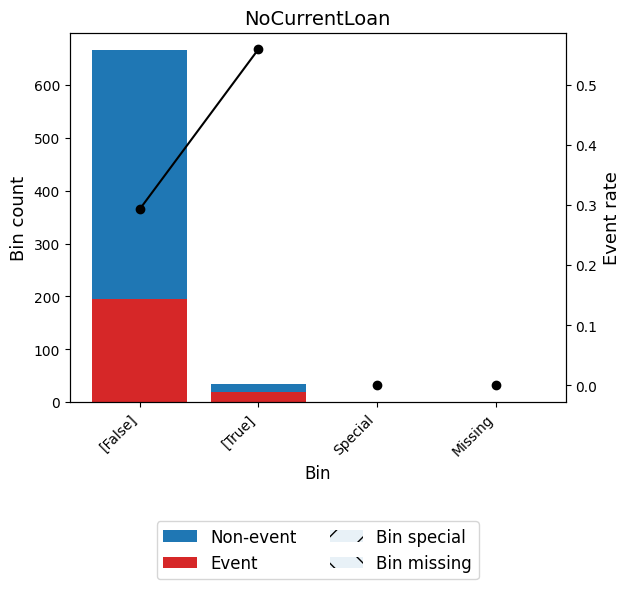

None


---

CriticalAccountOrLoansElsewhere 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0        [True]    200   0.285714        162     38    0.190000  0.629778   
1       [False]    500   0.714286        324    176    0.352000 -0.209973   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.098096  0.012063  
1       0.032706  0.004081  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.130802  0.016144  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.15576324
    IV (Jeffrey)             0.13080228
    JS (Jensen-Shannon)      0.01614409
    Hellinger                0.01624621
    Triangu

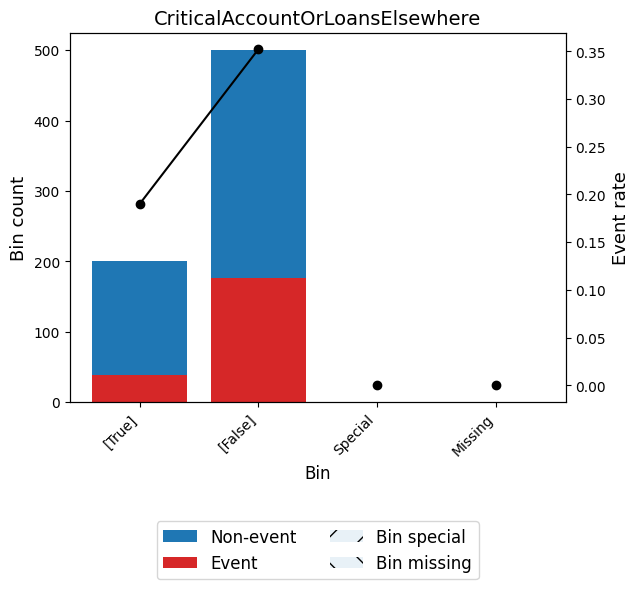

None


---

OtherLoansAtBank 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]    603   0.861429        430    173    0.286899  0.090261   
1           [1]     97   0.138571         56     41    0.422680 -0.508453   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.006893  0.000861  
1       0.038827  0.004802  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.045719  0.005663  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07636245
    IV (Jeffrey)             0.04571927
    JS (Jensen-Shannon)      0.00566300
    Hellinger                0.00568879
    Triangular            

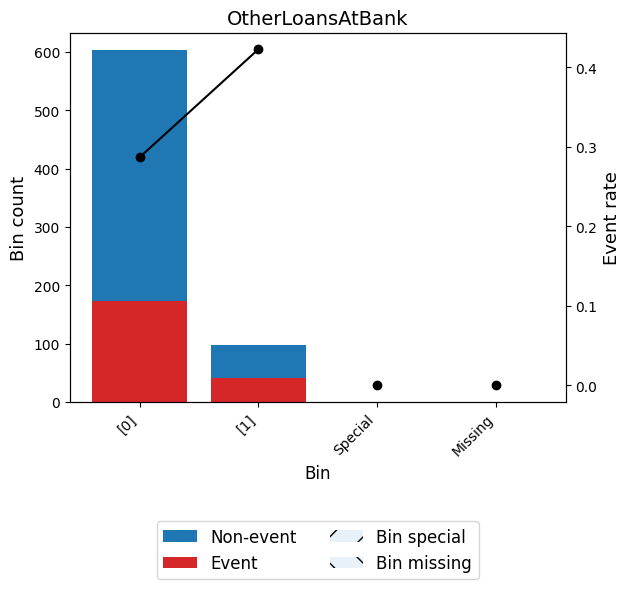

None


---

OtherLoansAtStore 

            Bin  Count  Count (%)  Non-event  Event  Event rate  WoE   IV   JS
0           [0]    700        1.0        486    214    0.305714  0.0  0.0  0.0
1       Special      0        0.0          0      0    0.000000  0.0  0.0  0.0
2       Missing      0        0.0          0      0    0.000000  0.0  0.0  0.0
Totals             700        1.0        486    214    0.305714       0.0  0.0
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend         

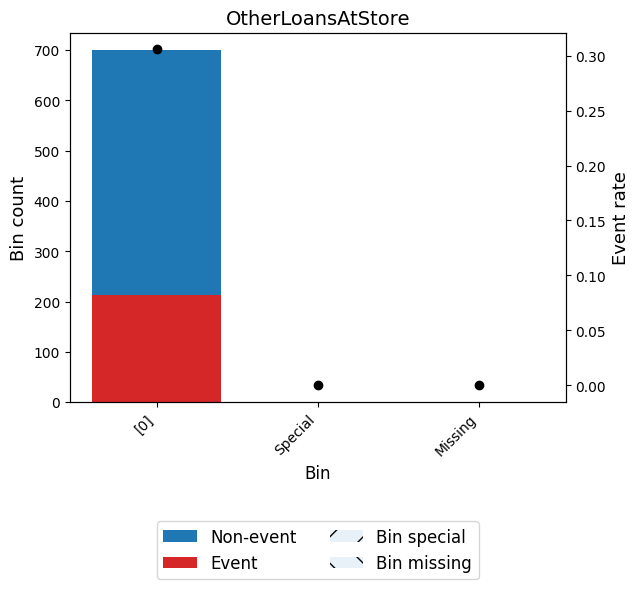

None


---

HasCoapplicant 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0       [False]    678   0.968571        473    205    0.302360  0.015853   
1        [True]     22   0.031429         13      9    0.409091 -0.452508   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.000243  0.000030  
1       0.006927  0.000859  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.007169  0.000889  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01530710
    IV (Jeffrey)             0.00716924
    JS (Jensen-Shannon)      0.00088884
    Hellinger                0.00089248
    Triangular              

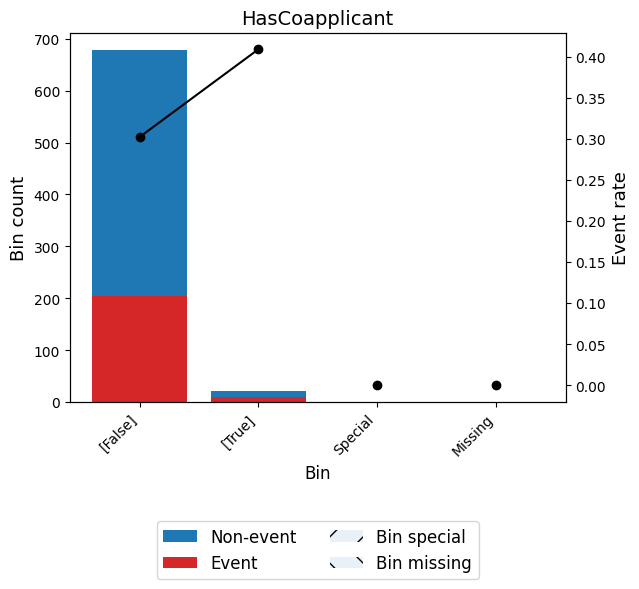

None


---

HasGuarantor 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]     42       0.06         35      7    0.166667  0.789205   
1           [0]    658       0.94        451    207    0.314590 -0.041484   
2       Special      0       0.00          0      0    0.000000       0.0   
3       Missing      0       0.00          0      0    0.000000       0.0   
Totals             700       1.00        486    214    0.305714             

              IV        JS  
0       0.031021  0.003780  
1       0.001631  0.000204  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.032651  0.003984  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.03930618
    IV (Jeffrey)             0.03265123
    JS (Jensen-Shannon)      0.00398379
    Hellinger                0.00403185
    Triangular               0

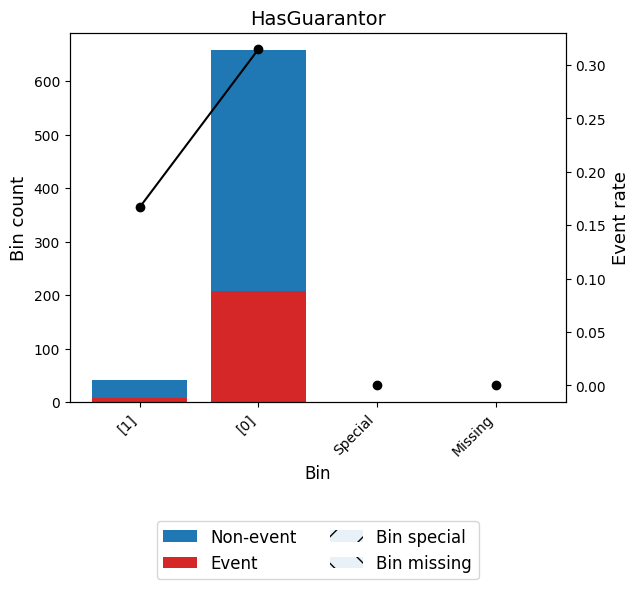

None


---

OwnsHouse 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    513   0.732857        372    141    0.274854  0.149901   
1           [0]    187   0.267143        114     73    0.390374 -0.374494   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.015973  0.001995  
1       0.039904  0.004959  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.055876  0.006954  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.10655359
    IV (Jeffrey)             0.05587617
    JS (Jensen-Shannon)      0.00695371
    Hellinger                0.00696906
    Triangular               0.02

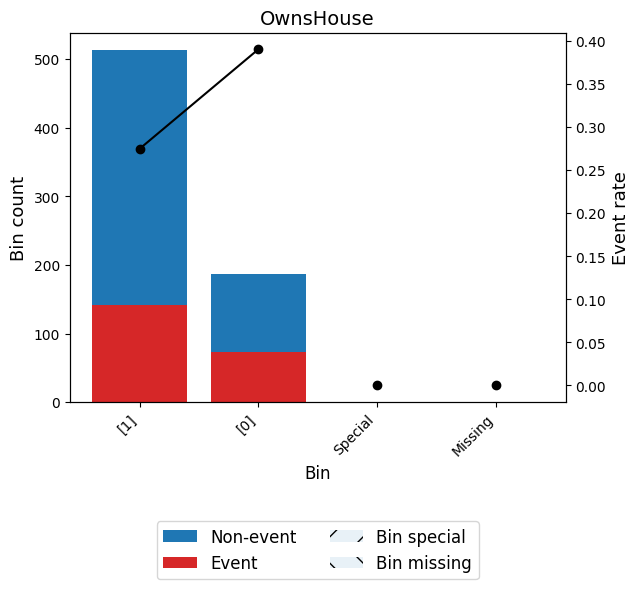

None


---

RentsHouse 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]    580   0.828571        414    166    0.286207  0.093646   
1           [1]    120   0.171429         72     48    0.400000 -0.414768   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.007131  0.000891  
1       0.031585  0.003920  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.038716  0.004811  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07615092
    IV (Jeffrey)             0.03871612
    JS (Jensen-Shannon)      0.00481113
    Hellinger                0.00482526
    Triangular               0.0

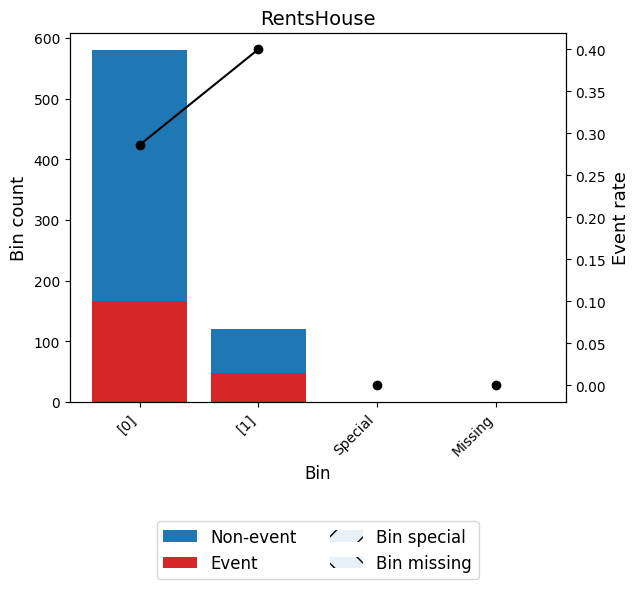

None


---

Unemployed 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]    656   0.937143        458    198    0.301829   0.01837   
1           [1]     44   0.062857         28     16    0.363636 -0.260617   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.000315  0.000039  
1       0.004470  0.000557  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.004786  0.000597  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01715319
    IV (Jeffrey)             0.00478551
    JS (Jensen-Shannon)      0.00059661
    Hellinger                0.00059740
    Triangular               0.0

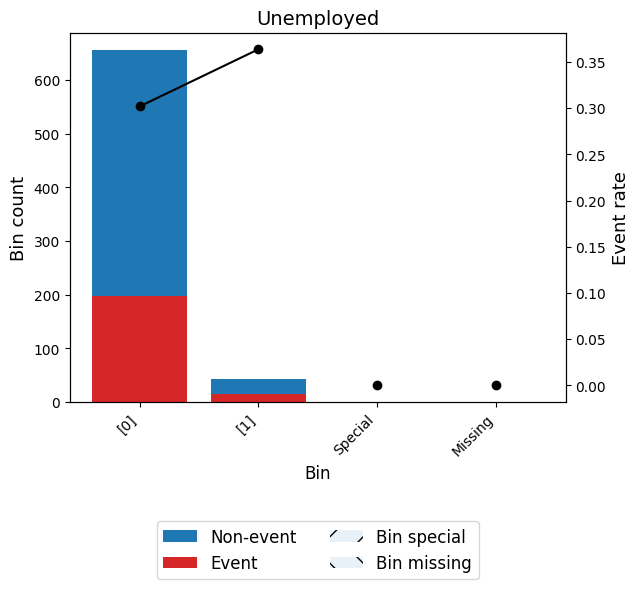

None


---

YearsAtCurrentJob_lt_1 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]    585   0.835714        419    166    0.283761  0.105651   
1           [1]    115   0.164286         67     48    0.417391 -0.486741   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.009132  0.001141  
1       0.042073  0.005208  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.051206  0.006349  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08643898
    IV (Jeffrey)             0.05120572
    JS (Jensen-Shannon)      0.00634888
    Hellinger                0.00637464
    Triangular      

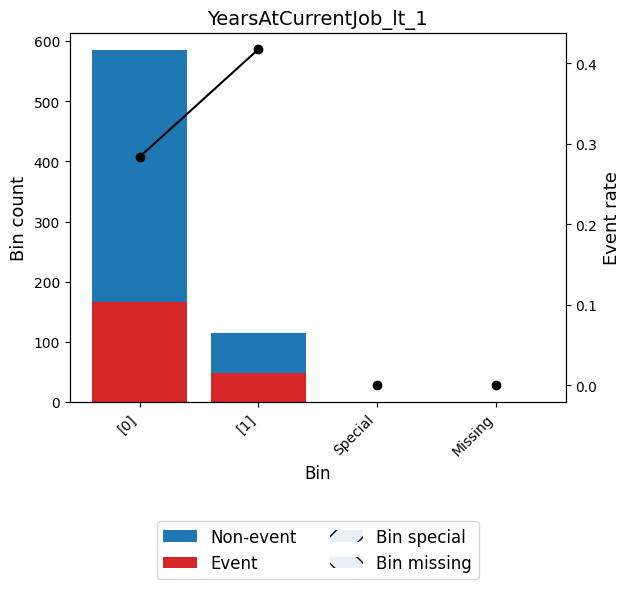

None


---

YearsAtCurrentJob_geq_4 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    299   0.427143        225     74    0.247492  0.291803   
1           [0]    401   0.572857        261    140    0.349127 -0.197355   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.034190  0.004259  
1       0.023124  0.002886  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.057314  0.007144  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.11716857
    IV (Jeffrey)             0.05731386
    JS (Jensen-Shannon)      0.00714445
    Hellinger                0.00715432
    Triangular     

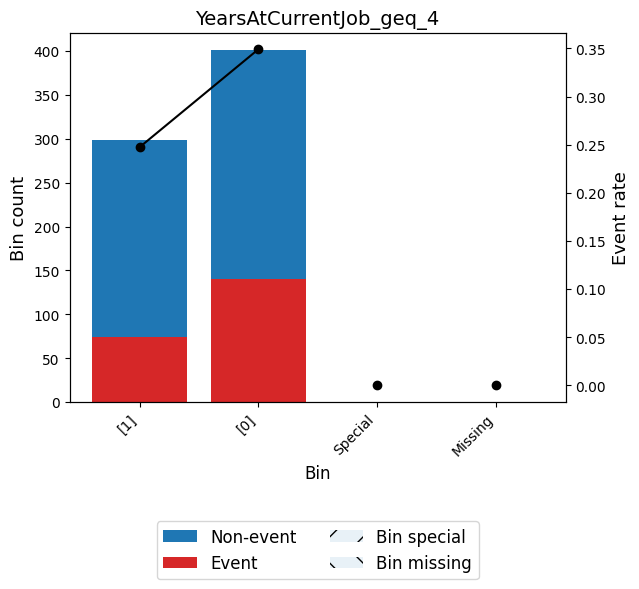

None


---

JobClassIsSkilled 

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]    540   0.771429        376    164    0.303704   0.00949   
1           [0]    160   0.228571        110     50    0.312500 -0.031775   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals             700   1.000000        486    214    0.305714             

              IV        JS  
0       0.000069  0.000009  
1       0.000232  0.000029  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.000302  0.000038  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00730741
    IV (Jeffrey)             0.00030154
    JS (Jensen-Shannon)      0.00003769
    Hellinger                0.00003769
    Triangular           

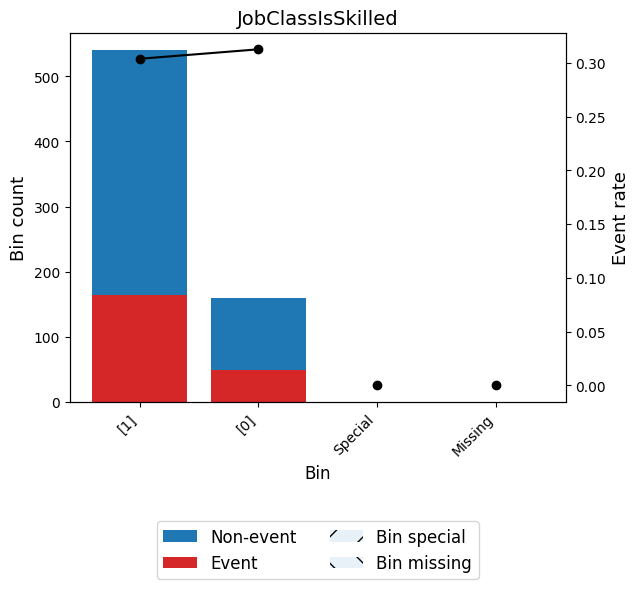

None


---

In [15]:
features = ['ForeignWorker', 'Single', 'Age',
       'LoanDuration', 'LoanAmount',
       'LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
       'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
       'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed',
       'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4',
       'JobClassIsSkilled']

for feature_name in features:
    print(feature_name, '\n')
    ob_univariate(X_train[feature_name],
                        y_train,
                        feature_name = feature_name,
                        dtype = binning_fit_params_woe[feature_name]['dtype'],
                        user_splits = binning_fit_params_woe[feature_name]['user_splits'],
                        user_splits_fixed = binning_fit_params_woe[feature_name]['user_splits_fixed'],
                        monotonic_trend = binning_fit_params_woe[feature_name]['monotonic_trend'],
                        plot=True)

    display(Markdown('---'))

In [16]:
ginis_dict = {'feature': [], 'gini': []}

for variable in features:
    optb = OptimalBinning(
            name=variable,
            user_splits=binning_fit_params_woe[variable]['user_splits'],
            user_splits_fixed=binning_fit_params_woe[variable]['user_splits_fixed'],
            solver=binning_fit_params_woe[variable]['solver'])
    
    binning_process = BinningProcess(
        variable_names=list(df[features].columns),
        binning_fit_params=binning_fit_params_woe)
    
    binning_process.fit(df[features], df['BadCustomer'])
      
    optb = binning_process.get_binned_variable(name=variable)
    binning_table = optb.binning_table.build()
    gini = round(optb.binning_table.gini, 4)
    #print(f"{variable} Gini: {gini}")
    
    ginis_dict['feature'].append(variable)
    ginis_dict['gini'].append(gini)

ginis_df = pd.DataFrame(ginis_dict)
ginis_df

,feature,gini
0,ForeignWorker,0.0338
1,Single,0.0876
2,Age,0.1201
3,LoanDuration,0.2662
4,LoanAmount,0.1582
5,LoanRateAsPercentOfIncome,0.0771
6,YearsAtCurrentHome,0.0143
7,NumberOfOtherLoansAtBank,0.0481
8,NumberOfLiableIndividuals,0.0024
9,HasTelephone,0.0390


### Correlation

In [17]:
X = df[features].copy()
## correlation matrix
corr_mat = X.corr(method='spearman')

# checking correlations above 50%
corr_thres = .5

np.fill_diagonal(corr_mat.values, 0)
high_corr_mat = corr_mat[corr_mat.abs() > corr_thres]
high_corr_pair_list = sorted(set([tuple(sorted(pair)) for pair in list(high_corr_mat.stack().index)]))

corr_features = []
for tup in high_corr_pair_list:
    for item in tup:
        corr_features.append(item)

print(high_corr_pair_list)

[('CriticalAccountOrLoansElsewhere', 'NumberOfOtherLoansAtBank'), ('LoanAmount', 'LoanDuration'), ('OwnsHouse', 'RentsHouse'), ('SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500')]


In [18]:
flat_list = [item for couple in high_corr_pair_list for item in couple]

ginis_df_corr = ginis_df[ginis_df['feature'].isin(flat_list)].sort_values(by='gini', ascending=False)
ginis_df_corr

,feature,gini
3,LoanDuration,0.2662
16,CriticalAccountOrLoansElsewhere,0.1805
4,LoanAmount,0.1582
21,OwnsHouse,0.1329
13,SavingsAccountBalance_geq_500,0.0776
22,RentsHouse,0.0776
12,SavingsAccountBalance_geq_100,0.0629
7,NumberOfOtherLoansAtBank,0.0481


In [19]:
selected_features = []
dropped_features = []
for feature_tuple in high_corr_pair_list:
    feature1, feature2 = feature_tuple
    gini1 = ginis_df_corr[ginis_df_corr['feature']==feature1]['gini'].values[0]
    gini2 = ginis_df_corr[ginis_df_corr['feature']==feature2]['gini'].values[0]
    if gini1 > gini2:
        selected_features.append(feature1)
        dropped_features.append(feature2)
    else:
        selected_features.append(feature2)
        dropped_features.append(feature1)
print(set(selected_features))

selected_feats = list(set(selected_features))

{'SavingsAccountBalance_geq_500', 'LoanDuration', 'CriticalAccountOrLoansElsewhere', 'OwnsHouse'}


In [20]:
ginis_df_uncorr = ginis_df[~ginis_df['feature'].isin(dropped_features)].sort_values(by='gini', ascending=False)
ginis_df_uncorr

,feature,gini
3,LoanDuration,0.2662
16,CriticalAccountOrLoansElsewhere,0.1805
21,OwnsHouse,0.1329
2,Age,0.1201
25,YearsAtCurrentJob_geq_4,0.1195
10,CheckingAccountBalance_geq_0,0.0924
24,YearsAtCurrentJob_lt_1,0.0876
1,Single,0.0876
13,SavingsAccountBalance_geq_500,0.0776
5,LoanRateAsPercentOfIncome,0.0771


In [21]:
mask = ginis_df_uncorr['gini'] >= 0.08
best_variables = ginis_df_uncorr[mask]
best_variables

,feature,gini
3,LoanDuration,0.2662
16,CriticalAccountOrLoansElsewhere,0.1805
21,OwnsHouse,0.1329
2,Age,0.1201
25,YearsAtCurrentJob_geq_4,0.1195
10,CheckingAccountBalance_geq_0,0.0924
24,YearsAtCurrentJob_lt_1,0.0876
1,Single,0.0876


In [22]:
from sklearn.model_selection import train_test_split
# Create an array of indices for your data
indices = np.arange(1000)

# Split the indices into train and test sets
train_val_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=62)

# Split the train indices into train and validation sets
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.3, random_state=62)

# Use the train, validation, and test indices as a mask for your data
train_mask = np.zeros((len(indices),), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((len(indices),), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((len(indices),), dtype=bool)
test_mask[test_idx] = True

In [23]:
# woe_model_feats = best_variables.feature.values.tolist()
# woe_lr_01 = create_woe_pipeline(X_train[woe_model_feats], X_test[woe_model_feats], y_train, y_test)
# print('model parameters:', woe_lr_01[1].intercept_, woe_lr_01[1].coef_) 

In [24]:
woe_model_feats = best_variables.feature.values.tolist()
woe_lr_01 = create_woe_pipeline(df_copy[woe_model_feats][train_mask], df_copy[woe_model_feats][test_mask] ,df_copy['BadCustomer'][train_mask], df_copy['BadCustomer'][test_mask])
print('model parameters:', woe_lr_01[1].intercept_, woe_lr_01[1].coef_) 

Gini : 40.29%
model parameters: [-0.80423372] [[-1.0462591  -0.78470638 -0.19833176 -0.74777829 -0.56444566 -0.49682826
  -0.56659848 -0.61499828]]


/Users/alessandrofogli/miniconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [25]:
# relative weights (Module 1)
st_weights = abs((np.std(woe_lr_01[0].transform(df_copy[woe_model_feats][train_mask]),0).to_numpy() * woe_lr_01[1].coef_))
sum_st_weights = np.sum(abs((np.std(woe_lr_01[0].transform(df_copy[woe_model_feats][train_mask]),0).to_numpy() * woe_lr_01[1].coef_)))
weight_vector = st_weights/sum_st_weights
weights = list(zip(df_copy[woe_model_feats][train_mask].columns, np.round(weight_vector, 3).ravel()))
df_features = pd.DataFrame(weights, columns=['feature', 'weight'])
print(df_features) # vectors of relative weights from logistic regression, utilization is the strongest feature

                           feature  weight
0                     LoanDuration   0.354
1  CriticalAccountOrLoansElsewhere   0.202
2                        OwnsHouse   0.022
3                              Age   0.139
4          YearsAtCurrentJob_geq_4   0.082
5     CheckingAccountBalance_geq_0   0.054
6           YearsAtCurrentJob_lt_1   0.075
7                           Single   0.071


### GNN and Ginis plot

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv,GINConv

from torch_geometric.utils import dropout_adj, convert
import torch.optim as optim

import networkx as nx

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import scipy.sparse as sp
import time
import os
import pickle
import random
import functions_file

In [41]:
def build_relationship(x, thresh=0.25):
    df_euclid = pd.DataFrame(1 / (1 + distance_matrix(x.T.T, x.T.T)), columns=x.T.columns, index=x.T.columns)
    df_euclid = df_euclid.to_numpy()
    idx_map = []
    for ind in range(df_euclid.shape[0]):
        max_sim = np.sort(df_euclid[ind, :])[-2]
        neig_id = np.where(df_euclid[ind, :] > thresh*max_sim)[0]
        import random
        random.seed(912)
        random.shuffle(neig_id)
        for neig in neig_id:
            if neig != ind:
                idx_map.append([ind, neig])
    # print('building edge relationship complete')
    idx_map =  np.array(idx_map)
    
    return idx_map

# from sklearn.neighbors import NearestNeighbors

# def build_relationship_knn(x, k):
#     # Compute the KNN graph
#     nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
#     nn.fit(x)
#     distances, indices = nn.kneighbors(x)

#     # Convert indices to edges
#     idx_map = []
#     for i, neighbors in enumerate(indices):
#         for neighbor in neighbors[1:]:
#             idx_map.append([i, neighbor])

#     return np.array(idx_map)

def load_german(dataset, predict_attr="GoodCustomer", path="./data/german/"):
    # print('Loading {} dataset from {}'.format(dataset, path))
    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)
    header.remove('OtherLoansAtStore')
    header.remove('PurposeOfLoan')

    # Sensitive Attribute
    idx_features_labels['Gender'][idx_features_labels['Gender'] == 'Female'] = 1
    idx_features_labels['Gender'][idx_features_labels['Gender'] == 'Male'] = 0

    # build relationship
    if os.path.exists(f'{path}/{dataset}_edges.txt'):
        edges_unordered = np.genfromtxt(f'{path}/{dataset}_edges.txt').astype('int')
    else:
        edges_unordered = build_relationship(idx_features_labels[header], thresh=0.8) # k=6
        np.savetxt(f'{path}/{dataset}_edges.txt', edges_unordered)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    #labels[labels == -1] = 0
    labels[labels == 1] = 0
    labels[labels == -1] = 1

    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)

    import random
    random.seed(62)
    label_idx_0 = np.where(labels==0)[0]
    label_idx_1 = np.where(labels==1)[0]
    random.shuffle(label_idx_0)
    random.shuffle(label_idx_1)

    # Calculate number of samples for each label in test and train sets
    num_label_1_test = int(label_idx_1.size * 0.3)
    num_label_0_test = int(label_idx_0.size * 0.3)
    num_label_1_train = label_idx_1.size - num_label_1_test
    num_label_0_train = label_idx_0.size - num_label_0_test

    # Split label indices for label 1 and label 0 into test and train sets
    idx_train_1 = label_idx_1[:num_label_1_train]
    idx_test_1 = label_idx_1[num_label_1_train:num_label_1_train+num_label_1_test]
    idx_train_0 = label_idx_0[:num_label_0_train]
    idx_test_0 = label_idx_0[num_label_0_train:num_label_0_train+num_label_0_test]

    # Concatenate indices to get final train and test sets
    idx_train = np.concatenate((idx_train_0, idx_train_1))
    idx_test = np.concatenate((idx_test_0, idx_test_1))

    # Shuffle final train and test sets
    random.seed(20)
    random.shuffle(idx_train)
    random.shuffle(idx_test)

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
   
    return adj, features, labels, idx_train, idx_test

In [42]:
predict_attr = "GoodCustomer"
path_german = "./data/german/"
adj, features, labels, idx_train, idx_test = load_german('german',
														predict_attr,
														path=path_german
														)

/var/folders/ym/64wd_02n4jb__shb_3lzm0zc0000gp/T/ipykernel_68775/2262108666.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_features_labels['Gender'][idx_features_labels['Gender'] == 'Female'] = 1
/var/folders/ym/64wd_02n4jb__shb_3lzm0zc0000gp/T/ipykernel_68775/2262108666.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_features_labels['Gender'][idx_features_labels['Gender'] == 'Male'] = 0


### Modular

In [145]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(nfeat, nhid)
        self.fc1 = nn.Linear(nhid, nhid//2) # add another linear layer
        self.fc2 = nn.Linear(nhid//2, nclass) # change the output dimension
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc1(x)) # add a relu activation
        x = self.fc2(x)
        return x

class GCN_Body(nn.Module):
    def __init__(self, nfeat, nhid):
        super(GCN_Body, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nhid) # add another graph convolution layer

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = F.relu(x)
        x = self.gc2(x, edge_index) # pass the output to another graph convolution layer
        x = F.relu(x)
        return x

from torch_geometric.nn import GCNConv


class GCNGerman(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCNGerman, self).__init__()
        self.body = GCN_Body_German(nfeat,nhid,dropout)
        self.fc = nn.Linear(nhid, nclass)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        x = self.fc(x)
        return x


class GCN_Body_German(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(GCN_Body_German, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        return x    


In [62]:
from torch_geometric.nn import GINConv

class GIN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GIN, self).__init__()

        self.mlp1 = nn.Sequential(
            nn.Linear(nfeat, nhid),
            nn.ReLU(),
            nn.BatchNorm1d(nhid),
            nn.Linear(nhid, nhid),
            nn.ReLU(),
            nn.BatchNorm1d(nhid),
        )
        self.conv1 = GINConv(self.mlp1)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class GINGerman(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout): 
        super(GINGerman, self).__init__()

        self.mlp1 = nn.Sequential(
            nn.Linear(nfeat, nhid), 
            nn.ReLU(),
            nn.BatchNorm1d(nhid),
            nn.Linear(nhid, nhid), 
        )
        self.conv1 = GINConv(self.mlp1)
        self.fc = nn.Linear(nhid, nclass)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)
        
    def forward(self, x, edge_index): 
        x = self.conv1(x, edge_index)
        return self.fc(x)

In [100]:
from torch_geometric.nn import GATConv


class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, num_heads=3, num_layers=1):
        super(GAT, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()

        # Input layer
        self.gat_layers.append(GATConv(nfeat, nhid, heads=num_heads, dropout=dropout))

        # Hidden layers
        for _ in range(1, num_layers):
            self.gat_layers.append(GATConv(nhid * num_heads, nhid, heads=num_heads, dropout=dropout))

        # Output layer
        self.fc = nn.Linear(nhid * num_heads, nclass)

    def forward(self, x, edge_index):
        h = x

        # Propagate through each GAT layer
        for layer in range(self.num_layers):
            h = self.gat_layers[layer](h, edge_index).flatten(1)
            h = F.elu(h)

        # Output layer
        x = self.fc(h)

        return x


In [122]:
# torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
#set seeds
n_seed = 1
np.random.seed(n_seed)
torch.manual_seed(n_seed)
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edge_index = convert.from_scipy_sparse_matrix(adj)[0]
edge_index = edge_index.to(device)
num_class = labels.unique().shape[0]-1
nfeat = features.shape[1]
seed = 90 #10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
num_epochs = 2500
features = features.to(device)
labels = labels.to(device)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# nhid = 16
# dropout = 0.5
# lr = 1e-3
# weight_decay = 1e-5
# model = GCN(nfeat=nfeat, nhid=nhid, nclass=num_class, dropout=dropout)
# model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [123]:
import time
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm


def train(model, optimizer, features, edge_index, labels, idx_train, device):
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index)
    
    preds = (output.squeeze() > 0).type_as(labels)
    loss_train = F.binary_cross_entropy_with_logits(output[idx_train], labels[idx_train].unsqueeze(1).float().to(device))
    
    auc_roc_train = roc_auc_score(labels.cpu().numpy()[idx_train], output.detach().cpu().numpy()[idx_train])
    loss_train.backward()
    optimizer.step()
    
    return loss_train.item()

def evaluate(model, features, edge_index, labels, idx_test, device):
    model.eval()
    output = model(features, edge_index)
    
    preds = (output.squeeze() > 0).type_as(labels)
    loss_test = F.binary_cross_entropy_with_logits(output[idx_test], labels[idx_test].unsqueeze(1).float().to(device))
    
    auc_roc_val = roc_auc_score(labels.cpu().numpy()[idx_test], output.detach().cpu().numpy()[idx_test])
    f1_val = f1_score(labels[idx_test].cpu().numpy(), preds[idx_test].cpu().numpy())
    
    return loss_test.item(), auc_roc_val, f1_val

def train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs):
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    
    epoch_iterator = tqdm(range(num_epochs + 1), desc='Epochs')
    #for epoch in range(num_epochs + 1):
    for epoch in epoch_iterator:
        t = time.time()
        loss_train = train(model, optimizer, features, edge_index, labels, idx_train, device)
        loss_test, auc_roc_val, f1_val = evaluate(model, features, edge_index, labels, idx_test, device)
        
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        
        if loss_test < best_loss:
            best_loss = loss_test
            torch.save(model.state_dict(), 'weights_vanilla.pt')
        
        if epoch % 100 == 0:
            #print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, num_epochs, loss_train, loss_test))
            epoch_iterator.set_postfix({'Train Loss': loss_train, 'Val Loss': loss_test})
    model.eval()
    output = model(features, edge_index)
    probs = torch.sigmoid(output)
    probs_gnn_1 = probs.squeeze()
    probs_gnn_array = np.vstack((1 - probs_gnn_1.cpu().detach().numpy(), probs_gnn_1.cpu().detach().numpy())).T
    preds = (output.squeeze() > 0).type_as(labels)
    f1_test = f1_score(labels[idx_test].cpu().numpy(), preds[idx_test].cpu().numpy())
    auc_roc_test = roc_auc_score(labels.cpu().numpy()[idx_test.cpu()], probs_gnn_array[idx_test][:, 1])

    return auc_roc_test

# Single run with fixed hyper-params
#train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs)


In [106]:
import optuna

def objective(trial):
    # Define the hyperparameters to tune
    dropout = trial.suggest_float('dropout', 0.2, 0.6)
    nhid = trial.suggest_int('nhid', 15, 35)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2)

    # Create the model with the specified hyperparameters
    model = GAT(nfeat, nhid, num_class, dropout)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train and evaluate the model
    auc_roc_test = train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs)
    
    # Return the AUC-ROC metric for optimization
    return ((auc_roc_test*2)-1)

initial_params = {
    "dropout": 0.5,
    "nhid": 16,
    "lr": 1e-3,
    "weight_decay": 1e-5
}

study_name = "GAT_german"
storage = f"study_{study_name}.pkl" 

try:
    # Load the existing study
    with open(storage, "rb") as f:
        study = pickle.load(f)
    print("Loaded previous study.")
except FileNotFoundError:
    # Create a new study if the file doesn't exist
    study = optuna.create_study(direction='maximize', study_name=study_name )
    study.enqueue_trial(initial_params)
    print("Created new study.")
    
study.optimize(objective, n_trials=5)
best_params = study.best_params
best_gini = study.best_value

with open(storage, "wb") as f:
    pickle.dump(study, f)
print("Study saved.")

print('Best Gini:', best_gini)
print('Best Hyperparameters:', best_params)


Loaded previous study.


Epochs: 100%|██████████| 2501/2501 [01:24<00:00, 29.49it/s, Train Loss=0.691, Val Loss=0.701]
[I 2023-05-24 11:00:38,046] Trial 15 finished with value: 0.18973544973544976 and parameters: {'dropout': 0.4367509509261734, 'nhid': 25, 'lr': 0.0003465226925856235, 'weight_decay': 0.0007053345853836532}. Best is trial 14 with value: 0.3045502645502647.
Epochs: 100%|██████████| 2501/2501 [01:19<00:00, 31.51it/s, Train Loss=0.589, Val Loss=0.589]
[I 2023-05-24 11:01:57,428] Trial 16 finished with value: 0.2688359788359791 and parameters: {'dropout': 0.5205216422683193, 'nhid': 19, 'lr': 0.002174601532722841, 'weight_decay': 0.0009059670722490145}. Best is trial 14 with value: 0.3045502645502647.
Epochs: 100%|██████████| 2501/2501 [01:36<00:00, 25.80it/s, Train Loss=0.557, Val Loss=0.589]
[I 2023-05-24 11:03:34,380] Trial 17 finished with value: 0.27121693121693125 and parameters: {'dropout': 0.43689842736687967, 'nhid': 31, 'lr': 0.0018475231655924918, 'weight_decay': 0.0011985461131473417}. 

Study saved.
Best Gini: 0.3045502645502647
Best Hyperparameters: {'dropout': 0.41727884538768983, 'nhid': 26, 'lr': 0.00023517493660855666, 'weight_decay': 0.0009893945834275652}


In [ ]:
import matplotlib.pyplot as plt
weights = model.body.gc1.lin.weight.detach().cpu().numpy().mean(axis=1)
plt.bar(range(len(weights)), weights)
plt.xticks(range(len(weights)), [str(i) for i in range(len(weights))])
plt.xlabel('Filter Index')
plt.ylabel('Weight')
plt.title('Weights of First Convolutional Layer')
plt.show()


### Retrieve model

In [139]:
study_name = "GCN_german"
storage = f"study_{study_name}.pkl" 

with open(storage, "rb") as f:
    study = pickle.load(f)

In [140]:
best_params = study.best_params
best_gini = study.best_value
model = GCN(nfeat, best_params['nhid'], num_class, best_params['dropout'])
model.to(device)
#model.load_state_dict(torch.load("weights_vanilla.pt"))
model.eval()
with torch.no_grad():
    output = model(features, edge_index)
    probs = torch.sigmoid(output)
    probs_gnn_1 = probs.squeeze()
    probs_gnn_array_gin = np.vstack((1 - probs_gnn_1.cpu().detach().numpy(), probs_gnn_1.cpu().detach().numpy())).T

In [141]:
best_params

{'dropout': 0.4086743882973184,
 'nhid': 17,
 'lr': 0.0009075054072684093,
 'weight_decay': 3.2961993338105435e-06}

In [142]:
best_gini

0.45566137566137566

In [146]:
def train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs):
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    
    epoch_iterator = tqdm(range(num_epochs + 1), desc='Epochs')
    #for epoch in range(num_epochs + 1):
    for epoch in epoch_iterator:
        t = time.time()
        loss_train = train(model, optimizer, features, edge_index, labels, idx_train, device)
        loss_test, auc_roc_val, f1_val = evaluate(model, features, edge_index, labels, idx_test, device)
        
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        
        if loss_test < best_loss:
            best_loss = loss_test

            # if architecture == 'GCN':
            #     torch.save(model.state_dict(), 'weights_vanilla_GCN.pt')

            # elif architecture == 'GIN':
            #     torch.save(model.state_dict(), 'weights_vanilla_GIN.pt')

            # else:
            #     torch.save(model.state_dict(), 'weights_vanilla_GAT.pt')
      
        if epoch % 100 == 0:
            #print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, num_epochs, loss_train, loss_test))
            epoch_iterator.set_postfix({'Train Loss': loss_train, 'Val Loss': loss_test})
    model.eval()
    output = model(features, edge_index)
    probs = torch.sigmoid(output)
    probs_gnn_1 = probs.squeeze()
    probs_gnn_array = np.vstack((1 - probs_gnn_1.cpu().detach().numpy(), probs_gnn_1.cpu().detach().numpy())).T
    auc_roc_test = roc_auc_score(labels.cpu().numpy()[idx_test.cpu()], probs_gnn_array[idx_test][:, 1])
    preds = (output.squeeze() > 0).type_as(labels)
    f1_test = f1_score(labels[idx_test].cpu().numpy(), preds[idx_test].cpu().numpy())

    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add a grid
    plt.savefig('loss_plot.png', dpi=200)  # Save the plot with 200 dpi resolution
    plt.show()

    return auc_roc_test, probs_gnn_array, f1_test

Epochs: 100%|██████████| 2501/2501 [00:24<00:00, 103.86it/s, Train Loss=0.578, Val Loss=0.571]


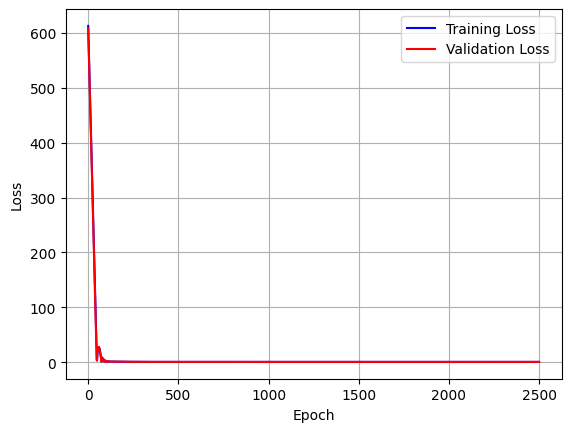

0.7248148148148148 0.4496296296296296 0.47904191616766467


In [147]:
model = GCNGerman(nfeat=nfeat, nhid=best_params['nhid'], nclass=num_class, dropout=best_params['dropout'])
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_auc, best_probs, f1_sc = train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs)
print(best_auc, best_auc*2-1, f1_sc)

/var/folders/ym/64wd_02n4jb__shb_3lzm0zc0000gp/T/ipykernel_80070/3955747852.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


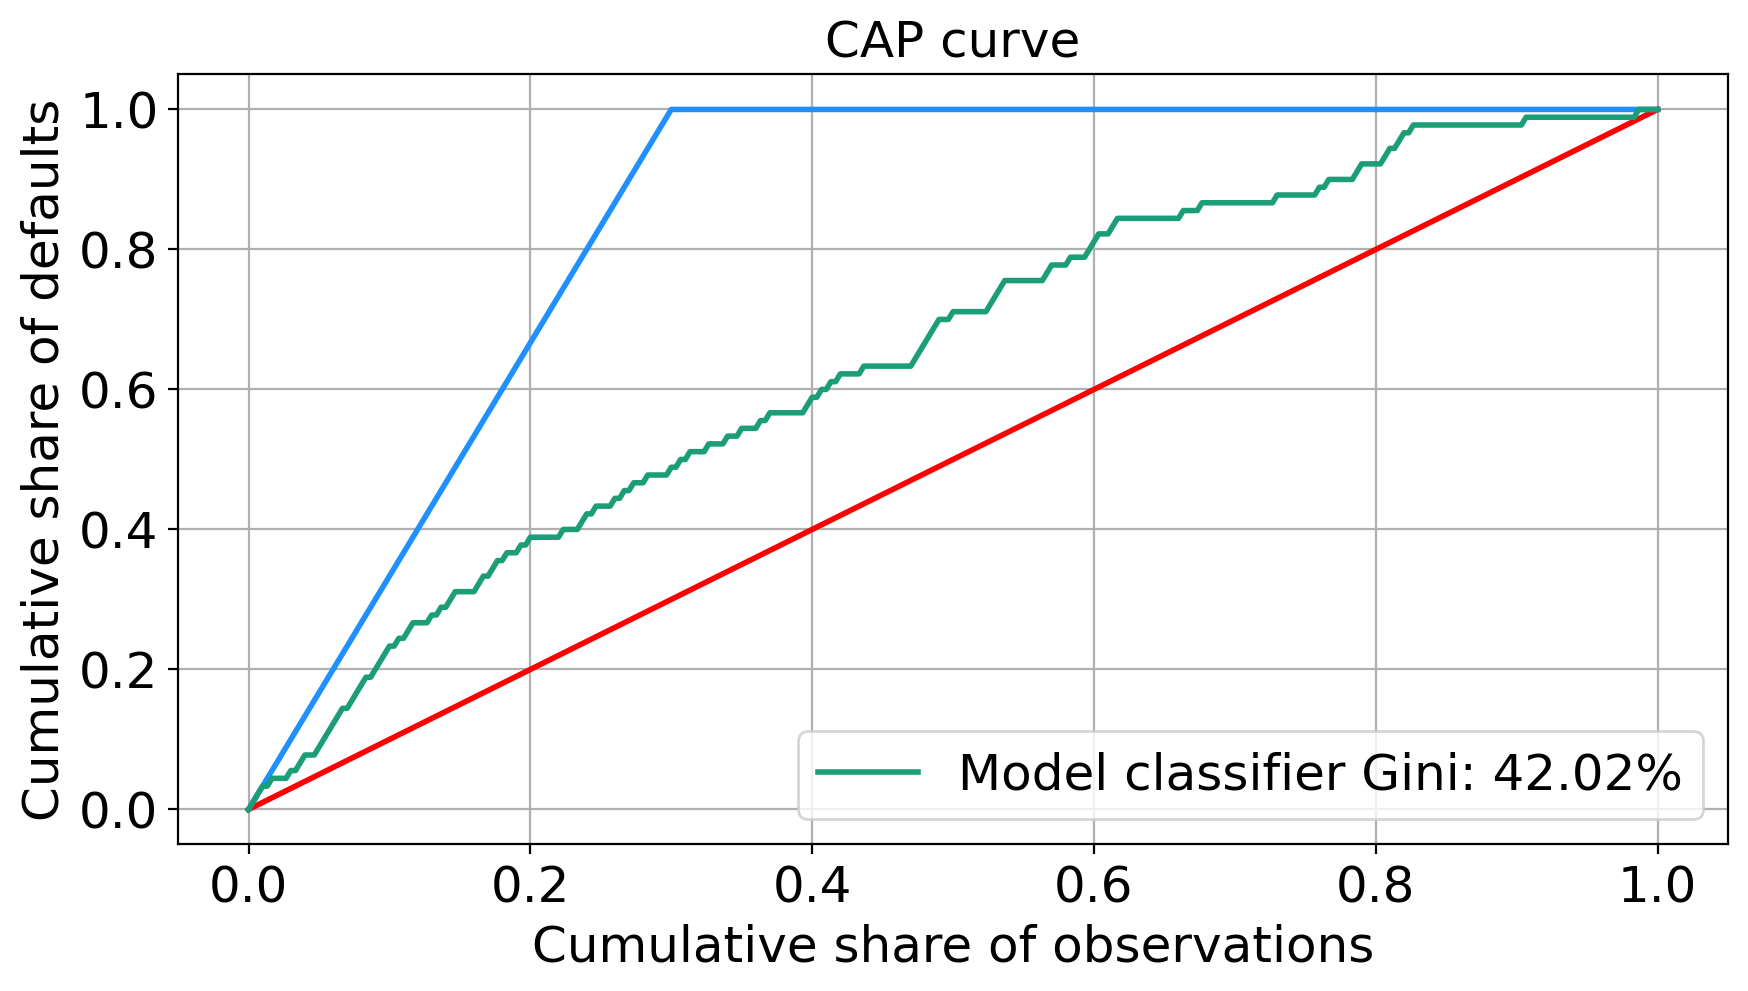

In [74]:
from matplotlib.gridspec import GridSpec
from plot_cap_curve import plot_cap # CAP curve (optbinning version adjusted for multiple curves)

# Discriminatory power
fig = plt.figure(figsize=(10, 5), dpi=200)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
plot_cap(df_copy.loc[idx_test.numpy(), 'BadCustomer'], woe_lr_01.predict_proba(df_copy.loc[idx_test.numpy(), woe_model_feats])[:,1], \
         model_name='Model classifier', line_color=colors(0))

plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Cumulative share of observations', fontsize=18)
plt.ylabel('Cumulative share of defaults', fontsize=18)

plt.title('CAP curve', fontsize=18)
plt.legend(fontsize=18) 
#plt.tight_layout()
plt.savefig('gini.png', bbox_inches='tight', transparent=True, dpi=200)
plt.show()

### Integration model

In [151]:
eps_=1.6e-10

def logit(p):
    p = p + eps_
    return np.log(p/(1-p))

In [152]:
woe_model_feats = best_variables.feature.values.tolist()
#woe_lr_01 = create_woe_pipeline(df_copy[woe_model_feats][train_mask], df_copy[woe_model_feats][test_mask] ,df_copy['BadCustomer'][train_mask], df_copy['BadCustomer'][test_mask])
woe_lr_01 = create_woe_pipeline(df_copy.loc[idx_train.numpy(), woe_model_feats], 
                                df_copy.loc[idx_test.numpy(), woe_model_feats] ,
                                df_copy.loc[idx_train.numpy(), 'BadCustomer'], 
                                df_copy.loc[idx_test.numpy(), 'BadCustomer']
                                )


print('model parameters:', woe_lr_01[1].intercept_, woe_lr_01[1].coef_) 

Gini : 0.4201587301587304
ROC-AUC : 0.7100793650793652
F1 Score : 0.35
model parameters: [-0.85065517] [[-1.01124285 -0.74463845 -0.78969074 -0.51980891 -0.70075038 -0.27058845
  -0.51418903 -0.3729453 ]]


/Users/alessandrofogli/miniconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [153]:
combined_scores_train = pd.DataFrame()
combined_scores_test = pd.DataFrame()

combined_scores_train['gnn_score'] = logit(best_probs[idx_train][:,1])
combined_scores_train['woe_score'] = logit(woe_lr_01.predict_proba(df_copy.loc[idx_train.numpy(), woe_model_feats])[:,1])
combined_scores_train['is_default'] = labels[idx_train].cpu().detach().numpy()


combined_scores_test['gnn_score'] = logit(best_probs[idx_test][:,1])
combined_scores_test['woe_score'] = logit(woe_lr_01.predict_proba(df_copy.loc[idx_test.numpy(), woe_model_feats])[:,1])
combined_scores_test['is_default'] = labels[idx_test].cpu().detach().numpy()


In [154]:
from sklearn.metrics import roc_auc_score, f1_score

integration_feats = ['gnn_score', 'woe_score']

def objective(trial):
    logreg_penalty = trial.suggest_categorical("logreg_penalty", ('l1', 'l2'))
    logreg_intercept_scaling = trial.suggest_float('logreg_intercept_scaling', 1e-3, 1, log=True)
    logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)

    classifier_obj = LogisticRegression(fit_intercept=True, solver='liblinear', C=logreg_c,
                                        penalty=logreg_penalty, random_state=72)
    
    classifier_obj.fit(combined_scores_train[integration_feats], combined_scores_train.is_default.to_numpy().ravel())
    
    # Store the classifier object in the user_attrs dictionary of the trial
    trial.set_user_attr('best_classifier', classifier_obj)

    # Scoring method:
    y_pred_proba = classifier_obj.predict_proba(combined_scores_test[integration_feats])
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)  # Apply threshold and convert to binary labels
    
    auc = roc_auc_score(labels[idx_test].cpu().detach().numpy(), y_pred_proba[:, 1])
    gini = auc * 2 - 1
    f1 = f1_score(labels[idx_test].cpu().numpy(), y_pred)
    
    return gini

# Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get the best trial's information
best_trial = study.best_trial
best_gini = best_trial.value

# Print the Gini, AUC, and F1 score for the best trial
best_classifier = best_trial.user_attrs['best_classifier']
best_y_pred_proba = best_classifier.predict_proba(combined_scores_test[integration_feats])
best_y_pred = (best_y_pred_proba[:, 1] >= 0.5).astype(int)
best_auc = roc_auc_score(labels[idx_test].cpu().detach().numpy(), best_y_pred_proba[:, 1])
best_f1 = f1_score(labels[idx_test].cpu().numpy(), best_y_pred)

print(f"Best Gini: {best_gini}")
print(f"Best AUC: {best_auc}")
print(f"Best F1 Score: {best_f1}")


[I 2023-05-24 11:33:50,701] A new study created in memory with name: no-name-093df402-adf4-4f6f-ae35-077babd52957
[I 2023-05-24 11:33:50,714] Trial 0 finished with value: 0.4650793650793652 and parameters: {'logreg_penalty': 'l2', 'logreg_intercept_scaling': 0.002387830789328469, 'logreg_c': 0.34485022635437845}. Best is trial 0 with value: 0.4650793650793652.
[I 2023-05-24 11:33:50,722] Trial 1 finished with value: 0.46105820105820094 and parameters: {'logreg_penalty': 'l2', 'logreg_intercept_scaling': 0.43342277730898177, 'logreg_c': 0.00013535242505061936}. Best is trial 0 with value: 0.4650793650793652.
[I 2023-05-24 11:33:50,730] Trial 2 finished with value: 0.4655026455026454 and parameters: {'logreg_penalty': 'l2', 'logreg_intercept_scaling': 0.007939733792418286, 'logreg_c': 300.85262768025757}. Best is trial 2 with value: 0.4655026455026454.
[I 2023-05-24 11:33:50,735] Trial 3 finished with value: 0.4655026455026454 and parameters: {'logreg_penalty': 'l1', 'logreg_intercept_sc

Best Gini: 0.466031746031746
Best AUC: 0.733015873015873
Best F1 Score: 0.34375


In [155]:
# Getting the best score:
print(f"The best value is : \n{study.best_value:.2%}")
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")

The best value is : 
46.60%
The best parameters are : 
{'logreg_penalty': 'l1', 'logreg_intercept_scaling': 0.08169325514268373, 'logreg_c': 3.6169089267691694}


In [156]:
#Get the best classifier object
best_classifier = study.best_trial.user_attrs['best_classifier']
#Get the predicted probabilities for label 1
y_pred_prob = best_classifier.predict_proba(combined_scores_test[integration_feats])[:, 1]

In [157]:
print(best_classifier.intercept_, best_classifier.coef_)

[-0.22616708] [[0.66572956 0.470626  ]]


/var/folders/ym/64wd_02n4jb__shb_3lzm0zc0000gp/T/ipykernel_68775/2925716018.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


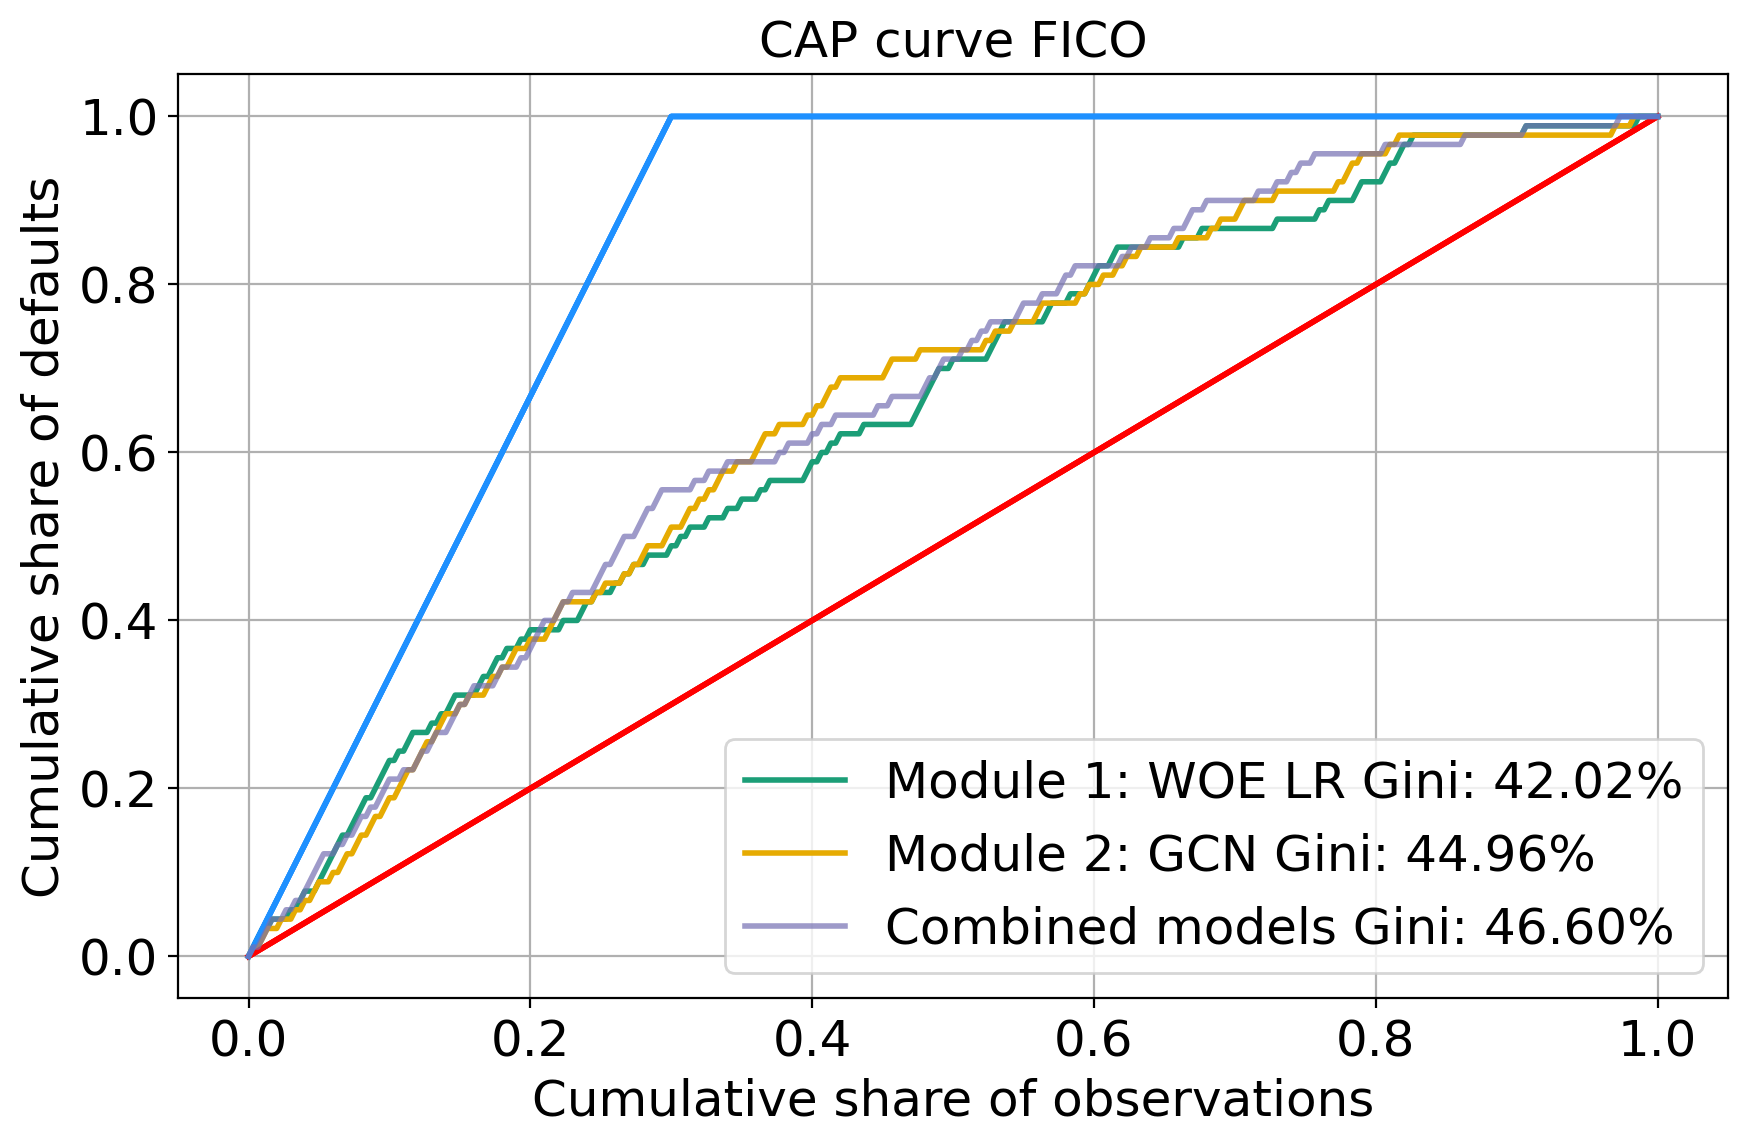

In [160]:
from matplotlib.gridspec import GridSpec
from plot_cap_curve import plot_cap # CAP curve (optbinning version adjusted for multiple curves)


output_labels_array = labels[idx_test].cpu().detach().numpy()
# Discriminatory power
fig = plt.figure(figsize=(10, 6), dpi=200)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
line_color = colors(2)
line_color = np.array(line_color)
line_color[3] = 0.7  # Adjust the transparency (alpha value) between 0 and 1
line_color = tuple(line_color)
plot_cap(df_copy.loc[idx_test.numpy(), 'BadCustomer'], woe_lr_01.predict_proba(df_copy.loc[idx_test.numpy(), woe_model_feats])[:,1], \
         model_name='Module 1: WOE LR', line_color=colors(0))
plot_cap(output_labels_array, best_probs[idx_test][:,1] , \
         model_name='Module 2: GCN', line_color=colors(5))
plot_cap(output_labels_array, y_pred_prob , \
         model_name='Combined models', line_color=line_color)

plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Cumulative share of observations', fontsize=18)
plt.ylabel('Cumulative share of defaults', fontsize=18)

plt.title('CAP curve FICO', fontsize=18)
plt.legend(fontsize=18) 
#plt.tight_layout()
#plt.savefig('graphics/discrimination_diagram.png', bbox_inches='tight')
plt.show()

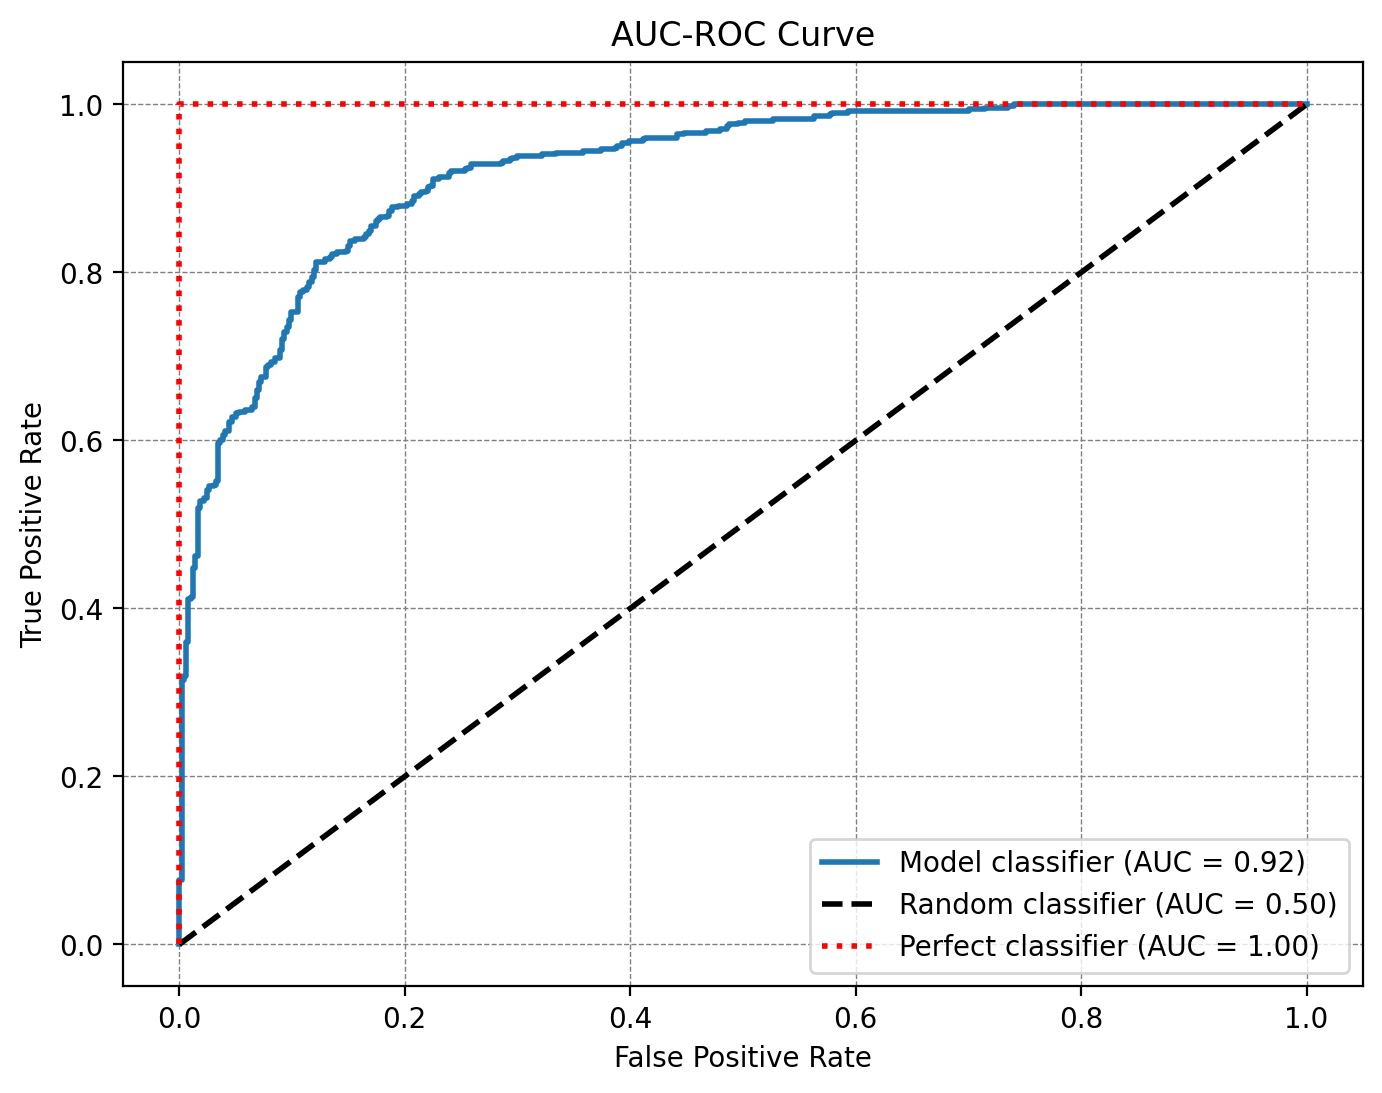

<Figure size 640x480 with 0 Axes>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Generate some sample data
n = 1000
y_true = np.random.randint(0, 2, n)  # True labels
y_pred = np.random.normal(0.6, 0.1, n) * y_true + np.random.normal(0.4, 0.1, n) * (1 - y_true) # Predicted probabilities

# Transform y_pred to have values between 0.5 and 1
y_pred = 0.5 + (y_pred - 0.3) / 1.4

# Calculate the auc score and the roc curve
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot the graph
plt.figure(figsize=(8, 6), dpi=200)
plt.plot(fpr, tpr, label='Model classifier (AUC = {:.2f})'.format(auc), lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.50)', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], 'r:', label='Perfect classifier (AUC = 1.00)', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Save the graph as an image file
plt.savefig('auc-roc.png')



### Features importance

In [35]:
# Our ML things
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset

from captum.attr import IntegratedGradients
from pytorch_lightning import seed_everything
from pytorch_lightning import Trainer
# Visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Utils
from enum import Enum
import pandas as pd
from sklearn.metrics import classification_report

In [36]:
# Let's start with the interpretation
STEP_AMOUNT = 50
SAMPLE_DIM = 5


# Since Captum is not directly
# made for Lightning,
# we need this wrapper
def modified_f(in_vec):
    # Changes the shapes correctly
    # X:Shape([SAMPLE_DIM*STEP_AMOUNT]=250)
    x = torch.reshape(in_vec,
        (int(in_vec.size()[0] / SAMPLE_DIM), SAMPLE_DIM)
    )
    # RES:Shape([50,5])
    # Since we have 50ti Batches and 5 features
    res = model.forward(x)
    # Again reshape to correct dims
    res = torch.reshape(res, (res.size()[0], 1))
    return res


ig = IntegratedGradients(modified_f)

In [ ]:
# define a collection
to_be_df = []
# Compare each element of the test set to out baselines
# we will than use this
for i in range(0,
               1):  # ts.__len__()):
    # load our test example
    in_val = ts.__getitem__(i)[0]
    # compare it to the 4 baselines
    att_b = ig.attribute(
        inputs=in_val,
        baselines=ts.base,
        n_steps=STEP_AMOUNT).detach().cpu().numpy()
    att_r = ig.attribute(
        inputs=in_val,
        baselines=torch.rand(
            5).cuda(),
        n_steps=STEP_AMOUNT).detach().cpu().numpy()
    att_z = ig.attribute(
        inputs=in_val,
        baselines=torch.zeros(
            5).cuda(),
        n_steps=STEP_AMOUNT).detach().cpu().numpy()
    att_1 = ig.attribute(
        inputs=in_val,
        baselines=torch.ones(
            5).cuda(),
        n_steps=STEP_AMOUNT).detach().cpu().numpy()
    # save result, this will produce a df
    # you can skip the details
    for base_type, vals in [
        ("mean-base", att_b),
        ("random-base", att_r),
        ("zero-base", att_z),
        ('one-base', att_1),
    ]:
        for i, name in enumerate(['Pclass',
                                  "Sex",
                                  "Age",
                                  "SibSp",
                                  "Fare"]):
            to_be_df.append({
                "base-type": base_type,
                "feature": name,
                "value": vals[i],
            })
# Convert our data to a pandas
df = pd.DataFrame(to_be_df)
df.to_csv('data/interpretation_results.csv')
print("OUR INTERPRETATION:\n\n",
      df)